In [1]:
#Checklist of stuff to do for code:
#1) Update saving times for RNN feedforward external inputs based on new stimuli - for now commented out
#2) Try out absolute magnitude threshold in combination with correlation based approach for determining stimuli responsiveness
#3) Figure out ideal parameter combos for determining groupings of neurons
#4) sort the calcium activity matrix into training data by grouping based on hierarchical clustering
#5) condense code a bit by converting multiple matrices into larger arrays
#6) Classify neurons according to whether they have increased calcium activity in the frame preceding and after a bout - this will be relevant
#for future datasets that include fish behavior.
#7) Attempt to use suite2p for processing data instead of caiman to see if it works better for lower resolution datasets - note, most of the code
#here would work for suite2p output, but we would need to convert the spatial coordinates provided by suite2p into caiman format. This should be
#easy enough with a single function.

## Code from Eva's lab for preprocessing 

In [3]:
#Import
#General Import Statements

import numpy as np
import os
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

from tkinter import Tk
from tkinter import filedialog as fd
from pathlib import Path
#from nptdms import TdmsFile
from datetime import datetime as dt
from datetime import date

import datetime
import shutil
import os
import copy
import tables

import numpy as np
np.seterr(all="ignore")

from datetime import datetime as dt
from numba import jit
from pathlib import Path
from tqdm.auto import tqdm

In [4]:
#Function for determining neuron ROIs within some mask boundary
def ROI_mask_overlap(neuron_array,all_nz_cal_act, img_path):
    import os
    import sys
    import tifffile

    l_dim = len(neuron_array[0])
    mask = tifffile.imread(img_path)
    neuron_arr = np.zeros(len(neuron_array))
    for i in np.arange(len(neuron_array)):
        o_product = np.multiply(mask,neuron_array[i])
        o_sum = np.sum(o_product)
        if o_sum > 0:
            neuron_arr[i] = 1
    pt_neuron_arr_ind = np.nonzero(neuron_arr)
    nz_cal_act = all_nz_cal_act[pt_neuron_arr_ind[0],:]
    nz_neuron_array = np.zeros((len(pt_neuron_arr_ind),l_dim,l_dim))
    for i in pt_neuron_arr_ind:
        nz_neuron_array = neuron_array[i]
    return nz_cal_act, nz_neuron_array

In [5]:
#Function for determining stimulus on times and also for saving times for turning on the feedforward RNN connections.
#Note, need to make changes to saving the feedforward RNN connections based on the new stimulus additions - work in progress

#Note, below are old comments:

# USE THIS ONE ---- UPDATED TO GET RGC INPUT COLUMN VECTORS
#Note, merge the column vectors to get rgc inputs - for instance outward + right + lateral_right for right eye right rgc
#The stimuli specific column vectors are necessary for visualization - for instance the line plots with colors showing
#When stimuli are on.

#Stim_frames: Takes frame_aligned h5 input from pandas_stim_aligner and outputs matrices length(n_frames) w/
#             1 when stim is on and 0 when it is off. Used for rgc input times in RNN.

#fa_path: path to frame_aligned h5 file
#N: Number of on frames

# fa_path = r'D:\data n188 4 28 22\frame_aligned.h5'
# output_path = r'D:\data n188 4 28 22\gcamp\planes\2tif_v2\stim_times_N_frames\test'
# Non = 5
# Nend = 1

def stim_frames(fa_path,output_path,Non,Nend,start_frame,nz_cal_act):
    df = pd.read_hdf(fa_path)
    stim_dict = {}
    for row in range(len(df)):
        stim = df.iloc[row].stim_name
        if stim not in stim_dict:
            stim_dict[stim] = []
        stim_dict[stim].append(df.iloc[row].img_stacks.values)

    fwd = stim_dict['forward']
    right = stim_dict['right']
    m_right = stim_dict['medial_right']
    l_right = stim_dict['lateral_right']
    bwd = stim_dict['backward']
    left = stim_dict['left']
    m_left = stim_dict['medial_left']
    l_left = stim_dict['lateral_left']
    inward = stim_dict['converging']
    outward = stim_dict['diverging']
    fwd_x = stim_dict['fwd_x']
    x_fwd = stim_dict['x_fwd']
    bwd_x = stim_dict['bwd_x']
    x_bwd = stim_dict['x_bwd']
    fwd_bwd = stim_dict['fwd_bwd']
    bwd_fwd = stim_dict['bwd_fwd']
    blank = stim_dict['blank']

    N = Non-Nend

    fwd_n = np.arange(len(fwd))
    fwd_on = np.zeros((len(fwd),N))
    fwd_on_exp = np.zeros((len(fwd),N+2))
    right_n = np.arange(len(right))
    right_on = np.zeros((len(right),N))
    right_on_exp = np.zeros((len(right),N+2))
    m_right_n = np.arange(len(m_right))
    m_right_on = np.zeros((len(m_right),N))
    m_right_on_exp = np.zeros((len(m_right),N+2))
    l_right_n = np.arange(len(l_right))
    l_right_on = np.zeros((len(l_right),N))
    l_right_on_exp = np.zeros((len(l_right),N+2))
    bwd_n = np.arange(len(bwd))
    bwd_on = np.zeros((len(bwd),N))
    bwd_on_exp = np.zeros((len(bwd),N+2))
    left_n = np.arange(len(left))
    left_on = np.zeros((len(left),N))
    left_on_exp = np.zeros((len(left),N+2))
    m_left_n = np.arange(len(m_left))
    m_left_on = np.zeros((len(m_left),N))
    m_left_on_exp = np.zeros((len(m_left),N+2))
    l_left_n = np.arange(len(l_left))
    l_left_on = np.zeros((len(l_left),N))
    l_left_on_exp = np.zeros((len(l_left),N+2))
    inward_n = np.arange(len(inward))
    inward_on = np.zeros((len(inward),N))
    inward_on_exp = np.zeros((len(inward),N+2))
    outward_n = np.arange(len(outward))
    outward_on = np.zeros((len(outward),N))
    outward_on_exp = np.zeros((len(outward),N+2))
    fwd_x_n = np.arange(len(fwd_x))
    fwd_x_on = np.zeros((len(fwd_x),N))
    fwd_x_on_exp = np.zeros((len(fwd_x),N+2))
    x_fwd_n = np.arange(len(x_fwd))
    x_fwd_on = np.zeros((len(x_fwd),N))
    x_fwd_on_exp = np.zeros((len(x_fwd),N+2))
    bwd_x_n = np.arange(len(bwd_x))
    bwd_x_on = np.zeros((len(bwd_x),N))
    bwd_x_on_exp = np.zeros((len(bwd_x),N+2))
    x_bwd_n = np.arange(len(x_bwd))
    x_bwd_on = np.zeros((len(x_bwd),N))
    x_bwd_on_exp = np.zeros((len(x_bwd),N+2))
    fwd_bwd_n = np.arange(len(fwd_bwd))
    fwd_bwd_on = np.zeros((len(fwd_bwd),N))
    fwd_bwd_on_exp = np.zeros((len(fwd_bwd),N+2))
    bwd_fwd_n = np.arange(len(bwd_fwd))
    bwd_fwd_on = np.zeros((len(bwd_fwd),N))
    bwd_fwd_on_exp = np.zeros((len(bwd_fwd),N+2))

    blank_start = 16
    blank_end = 1
    blank_n = np.arange(len(blank)-1)
    blank_on = np.zeros((len(blank)-1,blank_start-blank_end))






    #on frames for each display of stim

    for i in fwd_n:
        fwd_all = fwd[i]
        fwd_on[i] = fwd_all[-Non:-Nend]
        fwd_on_exp[i] = np.append(fwd_on[i],[fwd_on[i][-1]+1,fwd_on[i][-1]+2])
        fwd_on_exp[i] = np.array(fwd_on_exp[i], dtype='int16')
    fwd_on_exp = fwd_on_exp - start_frame

    for i in right_n:
        right_all = right[i]
        right_on[i] = right_all[-Non:-Nend]
        right_on_exp[i] = np.append(right_on[i],[right_on[i][-1]+1,right_on[i][-1]+2])
        right_on_exp[i] = np.array(right_on_exp[i], dtype='int16')
    right_on_exp = right_on_exp - start_frame

    for i in m_right_n:
        m_right_all = m_right[i]
        m_right_on[i] = m_right_all[-Non:-Nend]
        m_right_on_exp[i] = np.append(m_right_on[i],[m_right_on[i][-1]+1,m_right_on[i][-1]+2])
        m_right_on_exp[i] = np.array(m_right_on_exp[i], dtype='int16')
    m_right_on_exp = m_right_on_exp - start_frame

    for i in l_right_n:
        l_right_all = l_right[i]
        l_right_on[i] = l_right_all[-Non:-Nend]
        l_right_on_exp[i] = np.append(l_right_on[i],[l_right_on[i][-1]+1,l_right_on[i][-1]+2])
        l_right_on_exp[i] = np.array(l_right_on_exp[i], dtype='int16')
    l_right_on_exp = l_right_on_exp - start_frame

    for i in bwd_n:
        bwd_all = bwd[i]
        bwd_on[i] = bwd_all[-Non:-Nend]
        bwd_on_exp[i] = np.append(bwd_on[i],[bwd_on[i][-1]+1,bwd_on[i][-1]+2])
        bwd_on_exp[i] = np.array(bwd_on_exp[i], dtype='int16')
    bwd_on_exp = bwd_on_exp - start_frame

    for i in left_n:
        left_all = left[i]
        left_on[i] = left_all[-Non:-Nend]
        left_on_exp[i] = np.append(left_on[i],[left_on[i][-1]+1,left_on[i][-1]+2])
        left_on_exp[i] = np.array(left_on_exp[i], dtype='int16')
    left_on_exp = left_on_exp - start_frame

    for i in m_left_n:
        m_left_all = m_left[i]
        m_left_on[i] = m_left_all[-Non:-Nend]
        m_left_on_exp[i] = np.append(m_left_on[i],[m_left_on[i][-1]+1,m_left_on[i][-1]+2])
        m_left_on_exp[i] = np.array(m_left_on_exp[i], dtype='int16')
    m_left_on_exp = m_left_on_exp - start_frame

    for i in l_left_n:
        l_left_all = l_left[i]
        l_left_on[i] = l_left_all[-Non:-Nend]
        l_left_on_exp[i] = np.append(l_left_on[i],[l_left_on[i][-1]+1,l_left_on[i][-1]+2])
        l_left_on_exp[i] = np.array(l_left_on_exp[i], dtype='int16')
    l_left_on_exp = l_left_on_exp - start_frame

    for i in inward_n:
        inward_all = inward[i]
        inward_on[i] = inward_all[-Non:-Nend]
        inward_on_exp[i] = np.append(inward_on[i],[inward_on[i][-1]+1,inward_on[i][-1]+2])
        inward_on_exp[i] = np.array(inward_on_exp[i], dtype='int16')
    inward_on_exp = inward_on_exp - start_frame

    for i in outward_n:
        outward_all = outward[i]
        outward_on[i] = outward_all[-Non:-Nend]
        outward_on_exp[i] = np.append(outward_on[i],[outward_on[i][-1]+1,outward_on[i][-1]+2])
        outward_on_exp[i] = np.array(outward_on_exp[i], dtype='int16')
    outward_on_exp = outward_on_exp - start_frame

    for i in fwd_x_n:
        fwd_x_all = fwd_x[i]
        fwd_x_on[i] = fwd_x_all[-Non:-Nend]
        fwd_x_on_exp[i] = np.append(fwd_x_on[i],[fwd_x_on[i][-1]+1,fwd_x_on[i][-1]+2])
        fwd_x_on_exp[i] = np.array(fwd_x_on_exp[i], dtype='int16')
    fwd_x_on_exp = fwd_x_on_exp - start_frame

    for i in x_fwd_n:
        x_fwd_all = x_fwd[i]
        x_fwd_on[i] = x_fwd_all[-Non:-Nend]
        x_fwd_on_exp[i] = np.append(x_fwd_on[i],[x_fwd_on[i][-1]+1,x_fwd_on[i][-1]+2])
        x_fwd_on_exp[i] = np.array(x_fwd_on_exp[i], dtype='int16')
    x_fwd_on_exp = x_fwd_on_exp - start_frame

    for i in bwd_x_n:
        bwd_x_all = bwd_x[i]
        bwd_x_on[i] = bwd_x_all[-Non:-Nend]
        bwd_x_on_exp[i] = np.append(bwd_x_on[i],[bwd_x_on[i][-1]+1,bwd_x_on[i][-1]+2])
        bwd_x_on_exp[i] = np.array(bwd_x_on_exp[i], dtype='int16')
    bwd_x_on_exp = bwd_x_on_exp - start_frame

    for i in x_bwd_n:
        x_bwd_all = x_bwd[i]
        x_bwd_on[i] = x_bwd_all[-Non:-Nend]
        x_bwd_on_exp[i] = np.append(x_bwd_on[i],[x_bwd_on[i][-1]+1,x_bwd_on[i][-1]+2])
        x_bwd_on_exp[i] = np.array(x_bwd_on_exp[i], dtype='int16')
    x_bwd_on_exp = x_bwd_on_exp - start_frame

    for i in fwd_bwd_n:
        fwd_bwd_all = fwd_bwd[i]
        fwd_bwd_on[i] = fwd_bwd_all[-Non:-Nend]
        fwd_bwd_on_exp[i] = np.append(fwd_bwd_on[i],[fwd_bwd_on[i][-1]+1,fwd_bwd_on[i][-1]+2])
        fwd_bwd_on_exp[i] = np.array(fwd_bwd_on_exp[i], dtype='int16')
    fwd_bwd_on_exp = fwd_bwd_on_exp - start_frame

    for i in bwd_fwd_n:
        bwd_fwd_all = bwd_fwd[i]
        bwd_fwd_on[i] = bwd_fwd_all[-Non:-Nend]
        bwd_fwd_on_exp[i] = np.append(bwd_fwd_on[i],[bwd_fwd_on[i][-1]+1,bwd_fwd_on[i][-1]+2])
        bwd_fwd_on_exp[i] = np.array(bwd_fwd_on_exp[i], dtype='int16')
    bwd_fwd_on_exp = bwd_fwd_on_exp - start_frame

    for i in blank_n:
        blank_all = blank[i]
        blank_on[i] = blank_all[-blank_start:-blank_end]
        blank_on[i] = np.array(blank_on[i], dtype='int16')
    blank_on = blank_on - start_frame

    N_frames = len(nz_cal_act[0])

    fwd_on_test1 = np.array(fwd_on_exp, dtype='int16')
    fwd_on_test = np.concatenate(fwd_on_test1)
    fwd_test_N_frames = np.zeros(N_frames)
    for i in fwd_on_test:
        fwd_test_N_frames[i] = 1
    fwd_list_test = fwd_test_N_frames.tolist()
    fwd_df_list_test = pd.DataFrame(fwd_list_test)
    new_stim_path = os.path.join(output_path,f'{fwd}_stim_times.xlsx')
    #fwd_df_list_test.to_excel(os.path.join(output_path,f'fwd_stim_times.xlsx'), index=False)

    right_on_test1 = np.array(right_on_exp, dtype='int16')
    right_on_test = np.concatenate(right_on_test1)
    right_test_N_frames = np.zeros(N_frames)
    for i in right_on_test:
        right_test_N_frames[i] = 1
    right_list_test = right_test_N_frames.tolist()
    right_df_list_test = pd.DataFrame(right_list_test)
    #right_df_list_test.to_excel(os.path.join(output_path,f'right_stim_times.xlsx'), index=False)

    m_right_on_test1 = np.array(m_right_on_exp, dtype='int16')
    m_right_on_test = np.concatenate(m_right_on_test1)
    m_right_test_N_frames = np.zeros(N_frames)
    for i in m_right_on_test:
        m_right_test_N_frames[i] = 1
    m_right_list_test = m_right_test_N_frames.tolist()
    m_right_df_list_test = pd.DataFrame(m_right_list_test)
    #m_right_df_list_test.to_excel(os.path.join(output_path,f'm_right_stim_times.xlsx'), index=False)

    l_right_on_test1 = np.array(l_right_on_exp, dtype='int16')
    l_right_on_test = np.concatenate(l_right_on_test1)
    l_right_test_N_frames = np.zeros(N_frames)
    for i in l_right_on_test:
        l_right_test_N_frames[i] = 1
    l_right_list_test = l_right_test_N_frames.tolist()
    l_right_df_list_test = pd.DataFrame(l_right_list_test)
    #l_right_df_list_test.to_excel(os.path.join(output_path,f'l_right_stim_times.xlsx'), index=False)

    bwd_on_test1 = np.array(bwd_on_exp, dtype='int16')
    bwd_on_test = np.concatenate(bwd_on_test1)
    bwd_test_N_frames = np.zeros(N_frames)
    for i in bwd_on_test:
        bwd_test_N_frames[i] = 1
    bwd_list_test = bwd_test_N_frames.tolist()
    bwd_df_list_test = pd.DataFrame(bwd_list_test)
    #bwd_df_list_test.to_excel(os.path.join(output_path,f'bwd_stim_times.xlsx'), index=False)

    left_on_test1 = np.array(left_on_exp, dtype='int16')
    left_on_test = np.concatenate(left_on_test1)
    left_test_N_frames = np.zeros(N_frames)
    for i in left_on_test:
        left_test_N_frames[i] = 1
    left_list_test = left_test_N_frames.tolist()
    left_df_list_test = pd.DataFrame(left_list_test)
    #left_df_list_test.to_excel(os.path.join(output_path,f'left_stim_times.xlsx'), index=False)

    m_left_on_test1 = np.array(m_left_on_exp, dtype='int16')
    m_left_on_test = np.concatenate(m_left_on_test1)
    m_left_test_N_frames = np.zeros(N_frames)
    for i in m_left_on_test:
        m_left_test_N_frames[i] = 1
    m_left_list_test = m_left_test_N_frames.tolist()
    m_left_df_list_test = pd.DataFrame(m_left_list_test)
    #m_left_df_list_test.to_excel(os.path.join(output_path,f'm_left_stim_times.xlsx'), index=False)

    l_left_on_test1 = np.array(l_left_on_exp, dtype='int16')
    l_left_on_test = np.concatenate(l_left_on_test1)
    l_left_test_N_frames = np.zeros(N_frames)
    for i in l_left_on_test:
        l_left_test_N_frames[i] = 1
    l_left_list_test = l_left_test_N_frames.tolist()
    l_left_df_list_test = pd.DataFrame(l_left_list_test)
    #l_left_df_list_test.to_excel(os.path.join(output_path,f'l_left_stim_times.xlsx'), index=False)

    inward_on_test1 = np.array(inward_on_exp, dtype='int16')
    inward_on_test = np.concatenate(inward_on_test1)
    inward_test_N_frames = np.zeros(N_frames)
    for i in inward_on_test:
        inward_test_N_frames[i] = 1
    inward_list_test = inward_test_N_frames.tolist()
    inward_df_list_test = pd.DataFrame(inward_list_test)
    #inward_df_list_test.to_excel(os.path.join(output_path,f'inward_stim_times.xlsx'), index=False)

    outward_on_test1 = np.array(outward_on_exp, dtype='int16')
    outward_on_test = np.concatenate(outward_on_test1)
    outward_test_N_frames = np.zeros(N_frames)
    for i in outward_on_test:
        outward_test_N_frames[i] = 1
    outward_list_test = outward_test_N_frames.tolist()
    outward_df_list_test = pd.DataFrame(outward_list_test)
    #outward_df_list_test.to_excel(os.path.join(output_path,f'outward_stim_times.xlsx'), index=False)

    fwd_x_on_test1 = np.array(fwd_x_on_exp, dtype='int16')
    fwd_x_on_test = np.concatenate(fwd_x_on_test1)
    fwd_x_test_N_frames = np.zeros(N_frames)
    for i in fwd_x_on_test:
        fwd_x_test_N_frames[i] = 1
    fwd_x_list_test = fwd_x_test_N_frames.tolist()
    fwd_x_df_list_test = pd.DataFrame(fwd_x_list_test)
    new_stim_path = os.path.join(output_path,f'{fwd_x}_stim_times.xlsx')
    #fwd_x_df_list_test.to_excel(os.path.join(output_path,f'fwd_x_stim_times.xlsx'), index=False)

    x_fwd_on_test1 = np.array(x_fwd_on_exp, dtype='int16')
    x_fwd_on_test = np.concatenate(x_fwd_on_test1)
    x_fwd_test_N_frames = np.zeros(N_frames)
    for i in x_fwd_on_test:
        x_fwd_test_N_frames[i] = 1
    x_fwd_list_test = x_fwd_test_N_frames.tolist()
    x_fwd_df_list_test = pd.DataFrame(x_fwd_list_test)
    new_stim_path = os.path.join(output_path,f'{x_fwd}_stim_times.xlsx')
    #x_fwd_df_list_test.to_excel(os.path.join(output_path,f'x_fwd_stim_times.xlsx'), index=False)

    bwd_x_on_test1 = np.array(bwd_x_on_exp, dtype='int16')
    bwd_x_on_test = np.concatenate(bwd_x_on_test1)
    bwd_x_test_N_frames = np.zeros(N_frames)
    for i in bwd_x_on_test:
        bwd_x_test_N_frames[i] = 1
    bwd_x_list_test = bwd_x_test_N_frames.tolist()
    bwd_x_df_list_test = pd.DataFrame(bwd_x_list_test)
    new_stim_path = os.path.join(output_path,f'{bwd_x}_stim_times.xlsx')
    #bwd_x_df_list_test.to_excel(os.path.join(output_path,f'bwd_x_stim_times.xlsx'), index=False)

    x_bwd_on_test1 = np.array(x_bwd_on_exp, dtype='int16')
    x_bwd_on_test = np.concatenate(x_bwd_on_test1)
    x_bwd_test_N_frames = np.zeros(N_frames)
    for i in x_bwd_on_test:
        x_bwd_test_N_frames[i] = 1
    x_bwd_list_test = x_bwd_test_N_frames.tolist()
    x_bwd_df_list_test = pd.DataFrame(x_bwd_list_test)
    new_stim_path = os.path.join(output_path,f'{x_bwd}_stim_times.xlsx')
    #x_bwd_df_list_test.to_excel(os.path.join(output_path,f'x_bwd_stim_times.xlsx'), index=False)

    fwd_bwd_on_test1 = np.array(fwd_bwd_on_exp, dtype='int16')
    fwd_bwd_on_test = np.concatenate(fwd_bwd_on_test1)
    fwd_bwd_test_N_frames = np.zeros(N_frames)
    for i in fwd_bwd_on_test:
        fwd_bwd_test_N_frames[i] = 1
    fwd_bwd_list_test = fwd_bwd_test_N_frames.tolist()
    fwd_bwd_df_list_test = pd.DataFrame(fwd_bwd_list_test)
    new_stim_path = os.path.join(output_path,f'{fwd_bwd}_stim_times.xlsx')
    #fwd_bwd_df_list_test.to_excel(os.path.join(output_path,f'fwd_bwd_stim_times.xlsx'), index=False)

    bwd_fwd_on_test1 = np.array(bwd_fwd_on_exp, dtype='int16')
    bwd_fwd_on_test = np.concatenate(bwd_fwd_on_test1)
    bwd_fwd_test_N_frames = np.zeros(N_frames)
    for i in bwd_fwd_on_test:
        bwd_fwd_test_N_frames[i] = 1
    bwd_fwd_list_test = bwd_fwd_test_N_frames.tolist()
    bwd_fwd_df_list_test = pd.DataFrame(bwd_fwd_list_test)
    new_stim_path = os.path.join(output_path,f'{bwd_fwd}_stim_times.xlsx')
    #bwd_fwd_df_list_test.to_excel(os.path.join(output_path,f'bwd_fwd_stim_times.xlsx'), index=False)

    blank_on_test1 = np.array(blank_on, dtype='int16')
    blank_on_test = np.concatenate(blank_on_test1)
    blank_test_N_frames = np.zeros(N_frames)
    for i in blank_on_test:
        blank_test_N_frames[i] = 1
    blank_list_test = blank_test_N_frames.tolist()
    blank_df_list_test = pd.DataFrame(blank_list_test)
    #blank_df_list_test.to_excel(os.path.join(output_path,f'blank_stim_times.xlsx'), index=False)

    #rgc column vectors - note, the forward and backward rgcs for right and left eye are equivalent to fwd and bwd stim times
    #r_e_r_rgc_test_N_frames = np.add(right_test_N_frames,l_right_test_N_frames,outward_test_N_frames)
    #r_e_r_rgc_list_test = r_e_r_rgc_test_N_frames.tolist()
    #r_e_r_rgc_df_list_test = pd.DataFrame(r_e_r_rgc_list_test)
    #r_e_r_rgc_df_list_test.to_excel(os.path.join(output_path,f'right_eye_right_rgc_stim_times.xlsx'), index=False)

    #r_e_l_rgc_test_N_frames = np.add(left_test_N_frames,m_left_test_N_frames,inward_test_N_frames)
    #r_e_l_rgc_list_test = r_e_l_rgc_test_N_frames.tolist()
    #r_e_l_rgc_df_list_test = pd.DataFrame(r_e_l_rgc_list_test)
    #r_e_l_rgc_df_list_test.to_excel(os.path.join(output_path,f'right_eye_left_rgc_stim_times.xlsx'), index=False)

    #l_e_l_rgc_test_N_frames = np.add(left_test_N_frames,l_left_test_N_frames,outward_test_N_frames)
    #l_e_l_rgc_list_test = l_e_l_rgc_test_N_frames.tolist()
    #l_e_l_rgc_df_list_test = pd.DataFrame(l_e_l_rgc_list_test)
    #l_e_l_rgc_df_list_test.to_excel(os.path.join(output_path,f'left_eye_left_rgc_stim_times.xlsx'), index=False)

    #l_e_r_rgc_test_N_frames = np.add(right_test_N_frames,m_right_test_N_frames,inward_test_N_frames)
    #l_e_r_rgc_list_test = l_e_r_rgc_test_N_frames.tolist()
    #l_e_r_rgc_df_list_test = pd.DataFrame(l_e_r_rgc_list_test)
    #l_e_r_rgc_df_list_test.to_excel(os.path.join(output_path,f'left_eye_right_rgc_stim_times.xlsx'), index=False)

    return fwd_on_test,right_on_test,m_right_on_test,l_right_on_test,bwd_on_test,left_on_test,m_left_on_test,l_left_on_test,inward_on_test,outward_on_test,fwd_x_on_test,x_fwd_on_test,bwd_x_on_test,x_bwd_on_test,fwd_bwd_on_test,bwd_fwd_on_test,blank_on_test


In [6]:
#This function filters out the pretectal ROIs to include only neurons found to be responsive to at least one visual stimulus.
#Note, for the future I may consider also imposing a requirement based on the absolute magnitude of response of a neuron, since this would consider
#some neurons motion responsive as long as there is a relative increase in calcium activity, even if the total increase is small.

def get_stimuli_responsive_neurons(nz_cal_act,nz_neuron_array):#, pt_right_score, pt_m_right_score, pt_l_right_score, pt_left_score, pt_m_left_score, pt_l_left_score, pt_iwd_score, pt_owd_score, pt_fwd_score, pt_x_fwd_score, pt_fwd_x_score, pt_bwd_score, pt_x_bwd_score, pt_bwd_x_score, pt_fwd_bwd_score, pt_bwd_fwd_score):
    motion_sensitive_pt_cal_act = nz_cal_act
    motion_sensitive_pt_neuron_array = nz_neuron_array
    # motion_sensitivity = np.ones(len(nz_cal_act))
    # #ar_0 = np.reshape(cnm2.estimates.A[:,0].toarray(), dims, order='F')
    # #l_dim = len(ar_0)
    # l_dim = len(nz_neuron_array[0])

    # for i in np.arange(len(nz_cal_act)):
    #     if pt_right_score[i] == 0 and pt_m_right_score[i] == 0 and pt_l_right_score[i] == 0 and pt_left_score[i] == 0 and pt_m_left_score[i] == 0 and pt_l_left_score[i] == 0 and pt_iwd_score[i] == 0 and pt_owd_score[i] == 0 and pt_fwd_score[i] == 0 and pt_x_fwd_score[i] == 0 and pt_fwd_x_score[i] == 0 and pt_bwd_score[i] == 0 and pt_x_bwd_score[i] == 0 and pt_bwd_x_score[i] == 0 and pt_fwd_bwd_score[i] == 0 and pt_bwd_fwd_score[i] == 0:
    #     #if pt_fwd_score[i] == 0 and pt_right_score[i] == 0 and pt_m_right_score[i] == 0 and pt_l_right_score[i] == 0 and pt_bwd_score[i] == 0 and pt_left_score[i] == 0 and pt_m_left_score[i] == 0 and pt_l_left_score[i] == 0 and pt_iwd_score[i] == 0 and pt_owd_score[i] == 0:
    #         motion_sensitivity[i] = 0

    #     motion_sensitivity_index = np.nonzero(motion_sensitivity)
    #     motion_sensitive_pt_cal_act = nz_cal_act[motion_sensitivity_index[0],:]

    # motion_sensitive_pt_neuron_array = np.zeros((len(motion_sensitivity_index),l_dim,l_dim))
    # for i in motion_sensitivity_index:
    #    motion_sensitive_pt_neuron_array = nz_neuron_array[i]
    return motion_sensitive_pt_cal_act, motion_sensitive_pt_neuron_array

In [7]:
#Note: Start_Here takes you back here for rerunning multiple planes through
# Run_Again is for each code block you'll want to run again for each plane. Helpful for more quickly moving through the extremely verbose
# functions. Will be less of a problem once the code is properly cleaned up.

In [104]:
plane_index = 3

In [105]:
#Start_Here
#Run_Again

#Load data:
#Instructions: Start here and load in calcium activities (all_nz_cal_act) and spatial coordinates (all_nz_neuron_array) from each plane in the
#data folder. There will be a different number of planes for each dataset. You'll save these variables later and then you'll go back here and
#re-run until you arrive at the save step again for each plane
#NOTE: Google Colab is annoying because Capitalization matters for the path.
#NOTE: To get back here quicker, do ctrl+f: Start_Here
all_nz_cal_act = np.load(f'data/p{plane_index}/all_nz_cal_act.npy')
all_nz_neuron_array = np.load(f"data/p{plane_index}/all_nz_neuron_array.npy")

In [106]:
print(np.shape(all_nz_cal_act))
print(np.shape(all_nz_neuron_array))
#print(all_nz_neuron_array[0][10])

(900, 1299)
(900, 411, 411)


### Find neurons on pt

In [107]:
#Run_Again

#Input and Output for ROI_mask_overlap function
#Instructions on how to create masks: First, draw a mask capturing the pretectum in each plane. Do this by opening the data file in image J and
#sketching a boundary that agrees with the pretectal anatomy in the plane. Use this website as reference: https://zebrafishexplorer.zib.de/home/
#and select Diencephalon - Pretectum from the left dropdown menu. The pretectum should mostly be between planes 86 and 70 on the reference brain.
#Keep in mind that each plane are 2 microns apart. Typically, the pretectum spans about 30 microns in Z. For now, just use the masks in the plane
#folders that I created for each dataset. Later, you'll learn to create masks for your own data.

#Instructions for code: Use the same plane folder for the mask as was used for loading in the calcium activities and spatial coordinates
mask_path = f'data/p{plane_index}/Mask.tif'

#all_nz_cal_act are your calcium activities and all_nz_neuron_array are the spatial coordinates for the neurons.
pt_neurons_cal_act_and_array = ROI_mask_overlap(all_nz_neuron_array,all_nz_cal_act, mask_path)
all_nz_cal_act = pt_neurons_cal_act_and_array[0]
all_nz_neuron_array = pt_neurons_cal_act_and_array[1]

In [108]:
np.shape(all_nz_neuron_array)

(430, 1299)

In [ ]:
np.save(f'data/p{plane_index}/p{plane_index}_neuron_array_preprocessed.npy', all_nz_neuron_array)

In [109]:
#Instructions: Check if start_frame and stop_frame are beyond range of stims. The first frame during stimulus presentation is the first element
#in the first row array under column img_stacks. The last frame during stimulus presentation is the last element in the second to last row array
#under column img_stacks. The last row is a blank stimulus. Because fish have an 'On' and 'Off' Response to the projector being switch on and off,
#we want to crop the data so that we eliminate these responses. Generally, this means going around 10-50 frames before the first stimulus and after
#the last stimulus.
#NOTE: I have already checked the start and stop frames of all planes in the data I shared, so this step isn't necessary for the data I sent.
#However, this step will be necessary for future data that you collect.
test_path = f'data/p{plane_index}/frame_aligned.h5'
dftest_stims= pd.read_hdf(test_path)

In [110]:
#Run_Again
#Start and stop frame for cropping based on previous code block. These values work for all planes in the datasets I sent
start_frame = 75
stop_frame = 1225
all_nz_cal_act_crop = np.zeros((len(all_nz_cal_act),stop_frame-start_frame))
for i in np.arange(len(all_nz_cal_act)):
    for j in np.arange(stop_frame-start_frame):
        all_nz_cal_act_crop[i,j] = all_nz_cal_act[i,start_frame+j]

In [111]:
np.shape(all_nz_cal_act_crop)

(430, 1150)

In [112]:
#Run_Again

#Instructions: Use frame_aligned.h5 from the plane data folder. This will be the same folder you took the mask, calcium activities and spatial
#locations of neurons for a given run through the data.
fa_path = f'data/p{plane_index}/frame_aligned.h5'
#output_path = r'F:\[n277xn283]\d7 11 30 22 (same as d6 11 29 22)\imaging\1Hz\p6-p7\planes\stim_times' - this is for rgc inputs - need to update
output_path = f'data/p{plane_index}/output'
#Note: Non - is supposed to mean Number of on frame and Nend - is supposed to mean the final on frame. Start frame is the same as before
#In this set of data stimuli last 5 seconds and data is recorded at 1 frame per sec. However, there is a bit of variability in terms of the
# on frame, so I use a slightly wider definition for stimulus on period. Also, neurons will typically linger in their 'on' response about a
#second or so after a stimuli is turned off. This is mostly due to the slow decay of Gcamp6s.
Non = 6
Nend = 1
start_frame = 75

#Output. Note, the _on_test is basically a holdover name I was using. It could read as fwd_on_time_array or something like it instead
#but I was too lazy to change it :P
#Honestly, we should look into condensing at this point into one array with all stim times. Will probably get around to this soon.

stim_frames_output = stim_frames(fa_path,output_path,Non,Nend,start_frame,all_nz_cal_act_crop)

stim_frames_dict =  {'fwd_on_test': stim_frames_output[0],
    'right_on_test': stim_frames_output[1],
    'm_right_on_test': stim_frames_output[2],
    'l_right_on_test': stim_frames_output[3],
    'bwd_on_test': stim_frames_output[4],
    'left_on_test': stim_frames_output[5],
    'm_left_on_test': stim_frames_output[6],
    'l_left_on_test': stim_frames_output[7],
    'inward_on_test': stim_frames_output[8],
    'outward_on_test': stim_frames_output[9],
    'fwd_x_on_test': stim_frames_output[10],
    'x_fwd_on_test': stim_frames_output[11],
    'bwd_x_on_test': stim_frames_output[12],
    'x_bwd_on_test': stim_frames_output[13],
    'fwd_bwd_on_test': stim_frames_output[14],
    'bwd_fwd_on_test': stim_frames_output[15]}



fwd_on_test = stim_frames_output[0]
right_on_test = stim_frames_output[1]
m_right_on_test = stim_frames_output[2]
l_right_on_test = stim_frames_output[3]
bwd_on_test = stim_frames_output[4]
left_on_test = stim_frames_output[5]
m_left_on_test = stim_frames_output[6]
l_left_on_test = stim_frames_output[7]
inward_on_test = stim_frames_output[8]
outward_on_test = stim_frames_output[9]
fwd_x_on_test = stim_frames_output[10]
x_fwd_on_test = stim_frames_output[11]
bwd_x_on_test = stim_frames_output[12]
x_bwd_on_test = stim_frames_output[13]
fwd_bwd_on_test = stim_frames_output[14]
bwd_fwd_on_test = stim_frames_output[15]
blank_on_test = stim_frames_output[16]

In [113]:
stim_frames_dict['fwd_on_test']

array([ 289,  290,  291,  292,  293,  294,  295,  708,  709,  710,  711,
        712,  713,  714, 1048, 1049, 1050, 1051, 1052, 1053, 1054],
      dtype=int16)

In [114]:
print(np.shape(all_nz_cal_act_crop))

(430, 1150)


In [115]:
#Run_Again

#Note, this preprocesses the data. It normalizes each neuron trace from 0 to 1. It also computes baseline average and std.

nz_cal_act_pre = np.copy(all_nz_cal_act_crop)
print(np.shape(nz_cal_act_pre))
# nz_cal_act_baseline_vals = np.zeros((len(nz_cal_act_pre),len(blank_on_test)))
# nz_cal_act_baseline_average = np.zeros((len(nz_cal_act_pre)))
# nz_cal_act_baseline_std = np.zeros((len(nz_cal_act_pre)))
# counter = 0

# for i in np.arange(len(all_nz_cal_act_crop)):
#     nz_cal_act_max = np.amax(nz_cal_act_pre[i])
#     nz_cal_act_min = np.amin(nz_cal_act_pre[i])
#     #nz_cal_act_max[i] = np.amax(nz_cal_act_pre[i],axis=1)
#     for j in np.arange(len(all_nz_cal_act_crop[0])):
#         nz_cal_act_pre[i][j] = (nz_cal_act_pre[i][j]-nz_cal_act_min)/(nz_cal_act_max-nz_cal_act_min)
#         nz_cal_act_pre[i][j] = np.minimum(nz_cal_act_pre[i][j],.999)
#         nz_cal_act_pre[i][j] = np.maximum(nz_cal_act_pre[i][j],-.999)
#     for k in blank_on_test:
#         if counter > len(blank_on_test)-1:
#                 counter = 0
#         nz_cal_act_baseline_vals[i,counter] = nz_cal_act_pre[i,k]
#         nz_cal_act_baseline_average[i] = np.average(nz_cal_act_baseline_vals[i])
#         nz_cal_act_baseline_std[i] = np.std(nz_cal_act_baseline_vals[i])
#         counter = counter+1

(430, 1150)


In [116]:
np.save(f'data/p{plane_index}/proprocess_p{plane_index}.npy', all_nz_cal_act_crop)

In [117]:
print(np.min(nz_cal_act_pre), np.max(nz_cal_act_pre))

-0.5876869168196066 3.021296290809712


In [118]:
#Run_Again

#Output from above function. Motion_sensitive_pt_cal_act has calcium activities of neurons found to be motion responsive and
#motion_sensitive_pt_neuron_array has spatial coordinates of neurons found to be motion responsive

motion_sensitive_pt_neurons = get_stimuli_responsive_neurons(nz_cal_act_pre, all_nz_neuron_array)#, pt_right_score, pt_m_right_score, pt_l_right_score, pt_left_score, pt_m_left_score, pt_l_left_score, pt_iwd_score, pt_owd_score, pt_fwd_score, pt_x_fwd_score, pt_fwd_x_score, pt_bwd_score, pt_x_bwd_score, pt_bwd_x_score, pt_fwd_bwd_score, pt_bwd_fwd_score)
motion_sensitive_pt_cal_act = motion_sensitive_pt_neurons[0]
motion_sensitive_pt_neuron_array = motion_sensitive_pt_neurons[1]

In [119]:
np.shape(motion_sensitive_pt_cal_act)

(430, 1150)

In [122]:
#Save Variables step. This saves all important variables up until this point.
#Note, this saves the neuron activities and spatial coordinates, the stimulus on times, the arrays for whether a neuron responds to a stimulus,
#and both barcoding score arrays.
#Also, there are two versions of this function. One has _i_plane and one has _e_plane. The 'i' is for inhibitory and the 'e' is for excitatory
#This is because there are two types of lines I am using: one labels excitatory neurons (n277xn283) and the other labels inhibitory neurons
# (n284 x n283). Sometimes I want to load in data from fish across each line, so why i distinguish i vs e. It is also relevant for neurotransmitter
#labeling, since I have to use different preprocessing steps from determining glutamatergic vs GABAergic fluorescence.

#So, basically if you are running data from n277xn283, use the e_plane. If you are running data from n284xn283, use the i_plane. Also, if you are
#running data from multiple n284xn283 fish or multiple n277xn283 fish, what I've done is extend the plane number. Say there are 6 planes in fish_0
#and 5 planes in fish_1. Then I'd just make it go from p0 to p10, but note in a comment that p0 to p5 belong to fish_0 whereas p6 to p10 belong to
#fish_1. For the future, this should probably go in some sort of higher dimension array.

#In terms of strategy, I basically just copy one of the below blocks of text and put in a text editor. You could simply start another google colab
#notebook and just paste into a code block. Then do ctrl+f and type p0 or whatever the plane is that you are looking at and replace with p1 or
#whatever the next plane is. Then run the below code. When you're done, do ctrl+f and type 'Start_Here' to go back to the beginning and repeat for
#the next plane of data.


In [99]:
#Run_Again

#Save vars

#neuron activities and arrays
motion_sensitive_pt_neuron_array_i_p5 = motion_sensitive_pt_neuron_array
motion_sensitive_pt_cal_act_i_p5 = motion_sensitive_pt_cal_act

#stim on times
left_on_test_i_p5 = left_on_test
m_left_on_test_i_p5 = m_left_on_test
l_left_on_test_i_p5 = l_left_on_test
right_on_test_i_p5 = right_on_test
m_right_on_test_i_p5 = m_right_on_test
l_right_on_test_i_p5 = l_right_on_test
inward_on_test_i_p5 = inward_on_test
outward_on_test_i_p5 = outward_on_test
fwd_on_test_i_p5 = fwd_on_test
fwd_x_on_test_i_p5 = fwd_x_on_test
x_fwd_on_test_i_p5 = x_fwd_on_test
bwd_on_test_i_p5 = bwd_on_test
bwd_x_on_test_i_p5 = bwd_x_on_test
x_bwd_on_test_i_p5 = x_bwd_on_test
fwd_bwd_on_test_i_p5 = fwd_bwd_on_test
bwd_fwd_on_test_i_p5 = bwd_fwd_on_test

NameError: name 'pt_left_score' is not defined

In [ ]:
# np.save("/content/drive/MyDrive/o_t_output/pt_left_score.npy", pt_left_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_m_left_score.npy", pt_m_left_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_l_left_score.npy", pt_l_left_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_right_score.npy", pt_right_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_m_right_score.npy", pt_m_right_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_l_right_score.npy", pt_l_right_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_iwd_score.npy", pt_iwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_owd_score.npy", pt_owd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_fwd_score.npy", pt_fwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_fwd_x_score.npy", pt_fwd_x_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_x_fwd_score.npy", pt_x_fwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_bwd_score.npy", pt_bwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_bwd_x_score.npy", pt_bwd_x_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_x_bwd_score.npy", pt_x_bwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_fwd_bwd_score.npy", pt_fwd_bwd_score)
# np.save("/content/drive/MyDrive/o_t_output/pt_bwd_fwd_score.npy", pt_bwd_fwd_score)


In [ ]:
#Run_Again

#Save vars

#neuron activities and arrays
motion_sensitive_pt_neuron_array_e_p5 = motion_sensitive_pt_neuron_array
motion_sensitive_pt_cal_act_e_p5 = motion_sensitive_pt_cal_act

#stim on times
left_on_test_e_p5 = left_on_test
m_left_on_test_e_p5 = m_left_on_test
l_left_on_test_e_p5 = l_left_on_test
right_on_test_e_p5 = right_on_test
m_right_on_test_e_p5 = m_right_on_test
l_right_on_test_e_p5 = l_right_on_test
inward_on_test_e_p5 = inward_on_test
outward_on_test_e_p5 = outward_on_test
fwd_on_test_e_p5 = fwd_on_test
fwd_x_on_test_e_p5 = fwd_x_on_test
x_fwd_on_test_e_p5 = x_fwd_on_test
bwd_on_test_e_p5 = bwd_on_test
bwd_x_on_test_e_p5 = bwd_x_on_test
x_bwd_on_test_e_p5 = x_bwd_on_test
fwd_bwd_on_test_e_p5 = fwd_bwd_on_test
bwd_fwd_on_test_e_p5 = bwd_fwd_on_test


In [ ]:
# Below is basically the reverse of the Save Vars. Here we are loading the saved variables. As before, you'll want to change the plane index
# to whatever the current plane is.

In [ ]:
#Run_Again

#Load vars
motion_sensitive_pt_neuron_array = motion_sensitive_pt_neuron_array_i_p5
motion_sensitive_pt_cal_act = motion_sensitive_pt_cal_act_i_p5

left_on_test = left_on_test_i_p5
m_left_on_test = m_left_on_test_i_p5
l_left_on_test = l_left_on_test_i_p5
right_on_test = right_on_test_i_p5
m_right_on_test = m_right_on_test_i_p5
l_right_on_test = l_right_on_test_i_p5
inward_on_test = inward_on_test_i_p5
outward_on_test = outward_on_test_i_p5
fwd_on_test = fwd_on_test_i_p5
fwd_x_on_test = fwd_x_on_test_i_p5
x_fwd_on_test = x_fwd_on_test_i_p5
bwd_on_test = bwd_on_test_i_p5
bwd_x_on_test = bwd_x_on_test_i_p5
x_bwd_on_test = x_bwd_on_test_i_p5
fwd_bwd_on_test = fwd_bwd_on_test_i_p5
bwd_fwd_on_test = bwd_fwd_on_test_i_p5


In [123]:
#Run_Again

#This takes the neuron array for each plane and condenses it into an array with about 21 frames per each stimulus per each rep. This is condensed
#even further in later code

#NOTE: MUST CHANGE PLANE INDEX EACH TIME YOU RUN THIS! You'll want it to match the current plane number. The other values you can keep as they are
#for each run.

n_reps = 3
n_stim = 16
n_frames = 21*n_stim
#class_index = 0

#barcode_class = [pt_left_ob_score,pt_left_b_score,pt_left_ib_score,pt_left_iob_score,
#                pt_left_imm_score,pt_left_mm_score,pt_left_oml_score,pt_left_s_score,
#               pt_right_ob_score,pt_right_b_score,pt_right_ib_score,pt_right_iob_score,
#                pt_right_imm_score,pt_right_mm_score,pt_right_oml_score,pt_right_s_score]


#for b in np.arange(len(barcode_class)):
#    if len(np.nonzero(barcode_class[b])[0]) > 0:
#        #check if plane,class is empty
#        count_check[plane_index,class_index] = 1

left_interval = np.zeros((3,21))
m_left_interval = np.zeros((3,21))
l_left_interval = np.zeros((3,21))
right_interval = np.zeros((3,21))
m_right_interval = np.zeros((3,21))
l_right_interval = np.zeros((3,21))
inward_interval = np.zeros((3,21))
outward_interval = np.zeros((3,21))
fwd_interval = np.zeros((3,21))
fwd_x_interval = np.zeros((3,21))
x_fwd_interval = np.zeros((3,21))
bwd_interval = np.zeros((3,21))
bwd_x_interval = np.zeros((3,21))
x_bwd_interval = np.zeros((3,21))
fwd_bwd_interval = np.zeros((3,21))
bwd_fwd_interval = np.zeros((3,21))

stim_rep = 0
counter = 0
#Consider making the _intervals 3d arrays, with plane being index. - maybe later
for i in np.arange(3):
    for j in np.arange(7):
        left_interval[i,7+counter] = left_on_test[counter+stim_rep]
        m_left_interval[i,7+counter] = m_left_on_test[counter+stim_rep]
        l_left_interval[i,7+counter] = l_left_on_test[counter+stim_rep]
        right_interval[i,7+counter] = right_on_test[counter+stim_rep]
        m_right_interval[i,7+counter] = m_right_on_test[counter+stim_rep]
        l_right_interval[i,7+counter] = l_right_on_test[counter+stim_rep]
        inward_interval[i,7+counter] = inward_on_test[counter+stim_rep]
        outward_interval[i,7+counter] = outward_on_test[counter+stim_rep]
        fwd_interval[i,7+counter] = fwd_on_test[counter+stim_rep]
        fwd_x_interval[i,7+counter] = fwd_x_on_test[counter+stim_rep]
        x_fwd_interval[i,7+counter] = x_fwd_on_test[counter+stim_rep]
        bwd_interval[i,7+counter] = bwd_on_test[counter+stim_rep]
        bwd_x_interval[i,7+counter] = bwd_x_on_test[counter+stim_rep]
        x_bwd_interval[i,7+counter] = x_bwd_on_test[counter+stim_rep]
        fwd_bwd_interval[i,7+counter] = fwd_bwd_on_test[counter+stim_rep]
        bwd_fwd_interval[i,7+counter] = bwd_fwd_on_test[counter+stim_rep]
        counter = counter+1
    stim_rep = stim_rep+7
    counter = 0

for i in np.arange(3):
    for j in np.arange(8):
        left_interval[i,7-j] = left_interval[i,7] - j
        m_left_interval[i,7-j] = m_left_interval[i,7] - j
        l_left_interval[i,7-j] = l_left_interval[i,7] - j
        right_interval[i,7-j] = right_interval[i,7] - j
        m_right_interval[i,7-j] = m_right_interval[i,7] - j
        l_right_interval[i,7-j] = l_right_interval[i,7] - j
        inward_interval[i,7-j] = inward_interval[i,7] - j
        outward_interval[i,7-j] = outward_interval[i,7] - j
        fwd_interval[i,7-j] = fwd_interval[i,7] - j
        fwd_x_interval[i,7-j] = fwd_x_interval[i,7] - j
        x_fwd_interval[i,7-j] = x_fwd_interval[i,7] - j
        bwd_interval[i,7-j] = bwd_interval[i,7] - j
        bwd_x_interval[i,7-j] = bwd_x_interval[i,7] - j
        x_bwd_interval[i,7-j] = x_bwd_interval[i,7] - j
        fwd_bwd_interval[i,7-j] = fwd_bwd_interval[i,7] - j
        bwd_fwd_interval[i,7-j] = bwd_fwd_interval[i,7] - j

for i in np.arange(3):
    for j in np.arange(7):
        left_interval[i,14+j] = left_interval[i,13] + (j+1)
        m_left_interval[i,14+j] = m_left_interval[i,13] + (j+1)
        l_left_interval[i,14+j] = l_left_interval[i,13] + (j+1)
        right_interval[i,14+j] = right_interval[i,13] + (j+1)
        m_right_interval[i,14+j] = m_right_interval[i,13] + (j+1)
        l_right_interval[i,14+j] = l_right_interval[i,13] + (j+1)
        inward_interval[i,14+j] = inward_interval[i,13] + (j+1)
        outward_interval[i,14+j] = outward_interval[i,13] + (j+1)
        fwd_interval[i,14+j] = fwd_interval[i,13] + (j+1)
        fwd_x_interval[i,14+j] = fwd_x_interval[i,13] + (j+1)
        x_fwd_interval[i,14+j] = x_fwd_interval[i,13] + (j+1)
        bwd_interval[i,14+j] = bwd_interval[i,13] + (j+1)
        bwd_x_interval[i,14+j] = bwd_x_interval[i,13] + (j+1)
        x_bwd_interval[i,14+j] = x_bwd_interval[i,13] + (j+1)
        fwd_bwd_interval[i,14+j] = fwd_bwd_interval[i,13] + (j+1)
        bwd_fwd_interval[i,14+j] = bwd_fwd_interval[i,13] + (j+1)

#Create a matrix with the number of neurons barcoded in rows and columns being the frames
overlay_traces_left = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_m_left = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_l_left = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_right = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_m_right = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_l_right = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_inward = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_outward = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_fwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_fwd_x = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_x_fwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_bwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_bwd_x = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_x_bwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_fwd_bwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))
overlay_traces_bwd_fwd = np.zeros(((len(motion_sensitive_pt_cal_act)),3,21))

counter = 0
#for i in np.nonzero(barcode_class[b])[0]:
for i in np.arange(len(motion_sensitive_pt_cal_act)):
    for j in np.arange(3):
        for k in np.arange(21):
            frame_index = int(left_interval[j,k])
            overlay_traces_left[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(m_left_interval[j,k])
            overlay_traces_m_left[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(l_left_interval[j,k])
            overlay_traces_l_left[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(right_interval[j,k])
            overlay_traces_right[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(m_right_interval[j,k])
            overlay_traces_m_right[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(l_right_interval[j,k])
            overlay_traces_l_right[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(inward_interval[j,k])
            overlay_traces_inward[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(outward_interval[j,k])
            overlay_traces_outward[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(fwd_interval[j,k])
            overlay_traces_fwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(fwd_x_interval[j,k])
            overlay_traces_fwd_x[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(x_fwd_interval[j,k])
            overlay_traces_x_fwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(bwd_interval[j,k])
            overlay_traces_bwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(bwd_x_interval[j,k])
            overlay_traces_bwd_x[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(x_bwd_interval[j,k])
            overlay_traces_x_bwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(fwd_bwd_interval[j,k])
            overlay_traces_fwd_bwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
            frame_index = int(bwd_fwd_interval[j,k])
            overlay_traces_bwd_fwd[counter,j,k] = motion_sensitive_pt_cal_act[i,frame_index]
    counter = counter+1

exec(f'o_t_{plane_index} = np.concatenate((overlay_traces_inward,overlay_traces_outward,overlay_traces_left,overlay_traces_m_left,overlay_traces_l_left,overlay_traces_right,overlay_traces_m_right,overlay_traces_l_right,overlay_traces_fwd,overlay_traces_fwd_x,overlay_traces_x_fwd,overlay_traces_bwd,overlay_traces_bwd_x,overlay_traces_x_bwd,overlay_traces_fwd_bwd,overlay_traces_bwd_fwd),axis=2)')

#if len(np.nonzero(barcode_class[b])[0]) == 0:
#    exec(f'o_t_{class_index}_{plane_index} = np.array([]).reshape(0,n_reps,n_frames)')
#class_index = class_index + 1

In [124]:
#Above code generates a series of arrays: o_t_plane_index. The next code concatenates this into an array for data from fish that label inhibitory
#neurons (o_t_i) and an array for data from fish that label excitatory neurons (o_t_e). Run the block corresponding to your fish and change
#the number of planes accordingly.

In [58]:
print(np.shape(o_t_0))

(430, 3, 336)


In [ ]:
print(np.shape(o_t_1))

(324, 3, 336)


In [102]:
print(np.shape(o_t_2))

(353, 3, 336)


In [125]:
print(np.shape(o_t_3))

(430, 3, 336)


In [126]:
np.save(f"data/p{plane_index}/p{plane_index}_stim_preprocessed.npy", o_t_3)

In [ ]:
#For n284xn283 fish:
#Note, change o_t entries depending on number of planes
o_t_i = np.concatenate((o_t_0,o_t_1,o_t_2,o_t_3),axis=0)

In [ ]:
#For n277xn283 fish:
#Note, change o_t entries depending on number of planes
o_t_e = np.concatenate((o_t_0,o_t_1,o_t_2,o_t_3),axis=0)

In [ ]:
np.save(f"/content/drive/MyDrive/o_t_output/o_t_all.npy",o_t_e)

In [ ]:
print(np.shape(o_t_e))

(996, 3, 336)


### Model fitting start

In [ ]:
#For simplificty, the next code specificies whether o_t should be from o_t_i or o_t_e. Rewrite this each time you switch fish line data

In [ ]:
#For n277xn283 fish:
o_t = o_t_e

In [ ]:
#For n284xn283 fish:
o_t = o_t_i

In [ ]:
o_t_1 == o_t_0

<ipython-input-129-4684450ecd41>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  o_t_1 == o_t_0


False

In [ ]:
#This computes several arrays from the neuron array o_t
#It computes o_t_base, which takes the average baseline activity of each neuron across each stimulus repetition.
#o_t_on determines the peak response of the neuron during the stimulus on interval.
#o_t_diff computes the difference of o_t_on and o_t_base for each frame in the matrices.
#o_t_diff_mean takes the average across frames and provides a matrix that is Number of neurons x number of stimuli, where each
#element is the average difference in on peak response from baseline. This matrix is what is inputted into the hierarchical clustering package.

len_pre = 7
len_on = 7
o_t_base = np.zeros(shape=(len(o_t),n_stim,n_reps))
o_t_on = np.zeros(shape=(len(o_t),n_stim,n_reps))
o_t_diff = np.zeros(shape=(len(o_t),n_stim,n_reps))
o_t_diff_mean = np.zeros((len(o_t),n_stim))

for i in np.arange(len(o_t)):
    for j in np.arange(n_stim):
        for k in np.arange(n_reps):
            o_t_base[i,j,k] = np.mean(o_t[i][k][21*j:21*j+len_pre])
            o_t_on[i,j,k] = np.max(o_t[i][k][21*j+len_pre:21*j+len_pre+len_on])
            o_t_diff[i,j,k] = o_t_on[i][j][k] - o_t_base[i][j][k]
            o_t_diff_mean[i,j] = np.mean(o_t_diff[i][j])

In [ ]:
print(np.shape(o_t_on))
print(np.shape(o_t))

(1302, 16, 3)
(1302, 3, 336)


In [ ]:
#Following code blocks are to concatenate response scores to all stimuli. Split into e vs i for n277xn283 or n284xn283
#Below are for concatenating 6 different planes, but you could change this to whatever number of planes you are running through.
#This will probably be updated soon to be less verbose

In [ ]:
#For 6 planes
pt_left_score_i_all = np.concatenate((pt_left_score_i_p0,pt_left_score_i_p1,pt_left_score_i_p2,pt_left_score_i_p3,pt_left_score_i_p4,pt_left_score_i_p5),axis=None)
pt_left_m_score_i_all = np.concatenate((pt_left_m_score_i_p0,pt_left_m_score_i_p1,pt_left_m_score_i_p2,pt_left_m_score_i_p3,pt_left_m_score_i_p4,pt_left_m_score_i_p5),axis=None)
pt_left_l_score_i_all = np.concatenate((pt_left_l_score_i_p0,pt_left_l_score_i_p1,pt_left_l_score_i_p2,pt_left_l_score_i_p3,pt_left_l_score_i_p4,pt_left_l_score_i_p5),axis=None)
pt_right_score_i_all = np.concatenate((pt_right_score_i_p0,pt_right_score_i_p1,pt_right_score_i_p2,pt_right_score_i_p3,pt_right_score_i_p4,pt_right_score_i_p5),axis=None)
pt_right_m_score_i_all = np.concatenate((pt_right_m_score_i_p0,pt_right_m_score_i_p1,pt_right_m_score_i_p2,pt_right_m_score_i_p3,pt_right_m_score_i_p4,pt_right_m_score_i_p5),axis=None)
pt_right_l_score_i_all = np.concatenate((pt_right_l_score_i_p0,pt_right_l_score_i_p1,pt_right_l_score_i_p2,pt_right_l_score_i_p3,pt_right_l_score_i_p4,pt_right_l_score_i_p5),axis=None)
pt_iwd_score_i_all = np.concatenate((pt_iwd_score_i_p0,pt_iwd_score_i_p1,pt_iwd_score_i_p2,pt_iwd_score_i_p3,pt_iwd_score_i_p4,pt_iwd_score_i_p5),axis=None)
pt_owd_score_i_all = np.concatenate((pt_owd_score_i_p0,pt_owd_score_i_p1,pt_owd_score_i_p2,pt_owd_score_i_p3,pt_owd_score_i_p4,pt_owd_score_i_p5),axis=None)
pt_fwd_score_i_all = np.concatenate((pt_fwd_score_i_p0,pt_fwd_score_i_p1,pt_fwd_score_i_p2,pt_fwd_score_i_p3,pt_fwd_score_i_p4,pt_fwd_score_i_p5),axis=None)
pt_fwd_x_score_i_all = np.concatenate((pt_fwd_x_score_i_p0,pt_fwd_x_score_i_p1,pt_fwd_x_score_i_p2,pt_fwd_x_score_i_p3,pt_fwd_x_score_i_p4,pt_fwd_x_score_i_p5),axis=None)
pt_x_fwd_score_i_all = np.concatenate((pt_x_fwd_score_i_p0,pt_x_fwd_score_i_p1,pt_x_fwd_score_i_p2,pt_x_fwd_score_i_p3,pt_x_fwd_score_i_p4,pt_x_fwd_score_i_p5),axis=None)
pt_bwd_score_i_all = np.concatenate((pt_bwd_score_i_p0,pt_bwd_score_i_p1,pt_bwd_score_i_p2,pt_bwd_score_i_p3,pt_bwd_score_i_p4,pt_bwd_score_i_p5),axis=None)
pt_bwd_x_score_i_all = np.concatenate((pt_bwd_x_score_i_p0,pt_bwd_x_score_i_p1,pt_bwd_x_score_i_p2,pt_bwd_x_score_i_p3,pt_bwd_x_score_i_p4,pt_bwd_x_score_i_p5),axis=None)
pt_x_bwd_score_i_all = np.concatenate((pt_x_bwd_score_i_p0,pt_x_bwd_score_i_p1,pt_x_bwd_score_i_p2,pt_x_bwd_score_i_p3,pt_x_bwd_score_i_p4,pt_x_bwd_score_i_p5),axis=None)
pt_fwd_bwd_score_i_all = np.concatenate((pt_fwd_bwd_score_i_p0,pt_fwd_bwd_score_i_p1,pt_fwd_bwd_score_i_p2,pt_fwd_bwd_score_i_p3,pt_fwd_bwd_score_i_p4,pt_fwd_bwd_score_i_p5),axis=None)
pt_bwd_fwd_score_i_all = np.concatenate((pt_bwd_fwd_score_i_p0,pt_bwd_fwd_score_i_p1,pt_bwd_fwd_score_i_p2,pt_bwd_fwd_score_i_p3,pt_bwd_fwd_score_i_p4,pt_bwd_fwd_score_i_p5),axis=None)

In [ ]:
#For 6 planes
pt_left_score_e_all = np.concatenate((pt_left_score_e_p0,pt_left_score_e_p1,pt_left_score_e_p2,pt_left_score_e_p3,pt_left_score_e_p4,pt_left_score_e_p5),axis=None)
pt_left_m_score_e_all = np.concatenate((pt_left_m_score_e_p0,pt_left_m_score_e_p1,pt_left_m_score_e_p2,pt_left_m_score_e_p3,pt_left_m_score_e_p4,pt_left_m_score_e_p5),axis=None)
pt_left_l_score_e_all = np.concatenate((pt_left_l_score_e_p0,pt_left_l_score_e_p1,pt_left_l_score_e_p2,pt_left_l_score_e_p3,pt_left_l_score_e_p4,pt_left_l_score_e_p5),axis=None)
pt_right_score_e_all = np.concatenate((pt_right_score_e_p0,pt_right_score_e_p1,pt_right_score_e_p2,pt_right_score_e_p3,pt_right_score_e_p4,pt_right_score_e_p5),axis=None)
pt_right_m_score_e_all = np.concatenate((pt_right_m_score_e_p0,pt_right_m_score_e_p1,pt_right_m_score_e_p2,pt_right_m_score_e_p3,pt_right_m_score_e_p4,pt_right_m_score_e_p5),axis=None)
pt_right_l_score_e_all = np.concatenate((pt_right_l_score_e_p0,pt_right_l_score_e_p1,pt_right_l_score_e_p2,pt_right_l_score_e_p3,pt_right_l_score_e_p4,pt_right_l_score_e_p5),axis=None)
pt_iwd_score_e_all = np.concatenate((pt_iwd_score_e_p0,pt_iwd_score_e_p1,pt_iwd_score_e_p2,pt_iwd_score_e_p3,pt_iwd_score_e_p4,pt_iwd_score_e_p5),axis=None)
pt_owd_score_e_all = np.concatenate((pt_owd_score_e_p0,pt_owd_score_e_p1,pt_owd_score_e_p2,pt_owd_score_e_p3,pt_owd_score_e_p4,pt_owd_score_e_p5),axis=None)
pt_fwd_score_e_all = np.concatenate((pt_fwd_score_e_p0,pt_fwd_score_e_p1,pt_fwd_score_e_p2,pt_fwd_score_e_p3,pt_fwd_score_e_p4,pt_fwd_score_e_p5),axis=None)
pt_fwd_x_score_e_all = np.concatenate((pt_fwd_x_score_e_p0,pt_fwd_x_score_e_p1,pt_fwd_x_score_e_p2,pt_fwd_x_score_e_p3,pt_fwd_x_score_e_p4,pt_fwd_x_score_e_p5),axis=None)
pt_x_fwd_score_e_all = np.concatenate((pt_x_fwd_score_e_p0,pt_x_fwd_score_e_p1,pt_x_fwd_score_e_p2,pt_x_fwd_score_e_p3,pt_x_fwd_score_e_p4,pt_x_fwd_score_e_p5),axis=None)
pt_bwd_score_e_all = np.concatenate((pt_bwd_score_e_p0,pt_bwd_score_e_p1,pt_bwd_score_e_p2,pt_bwd_score_e_p3,pt_bwd_score_e_p4,pt_bwd_score_e_p5),axis=None)
pt_bwd_x_score_e_all = np.concatenate((pt_bwd_x_score_e_p0,pt_bwd_x_score_e_p1,pt_bwd_x_score_e_p2,pt_bwd_x_score_e_p3,pt_bwd_x_score_e_p4,pt_bwd_x_score_e_p5),axis=None)
pt_x_bwd_score_e_all = np.concatenate((pt_x_bwd_score_e_p0,pt_x_bwd_score_e_p1,pt_x_bwd_score_e_p2,pt_x_bwd_score_e_p3,pt_x_bwd_score_e_p4,pt_x_bwd_score_e_p5),axis=None)
pt_fwd_bwd_score_e_all = np.concatenate((pt_fwd_bwd_score_e_p0,pt_fwd_bwd_score_e_p1,pt_fwd_bwd_score_e_p2,pt_fwd_bwd_score_e_p3,pt_fwd_bwd_score_e_p4,pt_fwd_bwd_score_e_p5),axis=None)
pt_bwd_fwd_score_e_all = np.concatenate((pt_bwd_fwd_score_e_p0,pt_bwd_fwd_score_e_p1,pt_bwd_fwd_score_e_p2,pt_bwd_fwd_score_e_p3,pt_bwd_fwd_score_e_p4,pt_bwd_fwd_score_e_p5),axis=None)

In [ ]:
#This forms a N x num_frames array used for visualization of average neuron responses later

cell_array = np.zeros((len(o_t),21*n_stim))

for b in np.arange(len(o_t)):
    overlay_traces_mean = o_t[b].mean(axis=0)
    for j in np.arange(21*n_stim):
        cell_array[b,j] = overlay_traces_mean[j]

In [ ]:
np.shape(cell_array)

(1302, 336)

In [ ]:
#Code to classify neurons with hierarchical clustering. We are feeding in o_t_diff_mean from before.
#t is the distance paramter. t = 0.75 is the parameter I found to be somewhat reliable for resulting in a decent number of classes - generally you
#want this number to result in like 25-100 classes of neurons, though it will depend on how many planes and how many fish.

#See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster
#And: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fclusterdata.html#scipy.cluster.hierarchy.fclusterdata
#And: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
#And also: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
#For details on the parameters here. What I want you to do is to test out multiple parameter combinations. Here are the relevant parameters:

#1) t - this is either the threshold for forming clusters or the max number of clusters - the definition depends on the criterion parameter.
# For 'inconsistent', 'distance' or 'monocrit' criteria it is the threshold for forming clusters, but for 'maxclust' or 'maxclust_monocrit'
# it is the max number of clusters. Below I used 'distance' criteron, so t is the threshold. You might want to try adjusting t by like every .25
# or every .1 or so when trying to optimize.

#2) criterion - this details how the clusters are formed. There are 5 different criterion and the one selected impacts what 't' does and whether
# 'depth' matters. 'Depth' is another parameter but its value only matters if you are using the 'inconsistent' criterion

#3) metric - this specifices the calculation used for pairwise distances of observations or neurons. There are many different types but euclidean
#is the default. I recommend trying out cosine, since this was recommended to me previously. However, I'd try out all metrics. The metrics are under
#pdist and can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

#4) method - This is the linkage method. Default is single. Purpose is to compute distances among clusters
#Details are here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

#I would recommend creating arrays with the different values for all 4 of these parameters and trying to run the various combinations, possibly
#in a nested for loop or some other method so that you can quickly generate the clusters for each parameter combo. Let me know if you run into
#difficulty with this and I can help. You can use several methods to evaluate the quality of the classification. This will be discussed later.

In [ ]:
#As a general strategy, you should run the following code block with some paramter combination and then run the subsequent code that eventually
#results in visualizing the clusters formed. As mentioned before, you'll want to observe a reasonable number of clusters that are sufficiently
#different from each other in terms of stimulus selectivity and dynamics (for example, are neurons suppressed or not).

#Note, there is additional code for neurotransmitter overlap and visualizing the neuroanatomy of clusters, but I need to make a few edits to the
#code and upload some additional files before sharing. This will probably take me a couple of days.

In [ ]:
#Hierarchical clustering code - details in comments in previous block
#Note: t is a distance parameter (or at least usually is, though depends on criterion), whereas T is the resulting clustered input array

import scipy.cluster.hierarchy as sch

vals = np.nan_to_num(o_t_diff_mean)

d = sch.distance.pdist(vals)
Z = sch.linkage(d, method='complete')

t = 0.75
T = sch.fcluster(Z, t, criterion='distance', depth=3)

In [ ]:
#Get a sense of the characteristics of T.
test_values, test_indices, test_counts = np.unique(T, return_counts=True, return_index=True)

(array([ 2.,  4.,  4., 14., 14., 10.,  9.,  2.,  5.,  1., 10., 18., 19.,
         1.,  4.,  1.,  1.,  3.,  8.,  3., 61., 56., 59.,  5., 45., 37.,
        21., 37.,  5., 16., 11., 18., 10., 12., 36., 99., 26., 16., 13.,
        17., 57.,  6.,  9.,  5.,  8.,  5.,  4.,  1., 12., 30., 10.,  4.,
        21., 16., 12., 16.,  6.,  5.,  7.,  1.,  3.,  1., 10.,  8., 17.,
         4., 11.,  4.,  3.,  5.,  4.,  3., 18., 21.,  6.,  3.,  8.,  4.,
         8., 60.,  7., 10., 10.,  2.,  6.]),
 array([ 1.        ,  1.98823529,  2.97647059,  3.96470588,  4.95294118,
         5.94117647,  6.92941176,  7.91764706,  8.90588235,  9.89411765,
        10.88235294, 11.87058824, 12.85882353, 13.84705882, 14.83529412,
        15.82352941, 16.81176471, 17.8       , 18.78823529, 19.77647059,
        20.76470588, 21.75294118, 22.74117647, 23.72941176, 24.71764706,
        25.70588235, 26.69411765, 27.68235294, 28.67058824, 29.65882353,
        30.64705882, 31.63529412, 32.62352941, 33.61176471, 34.6       ,
      

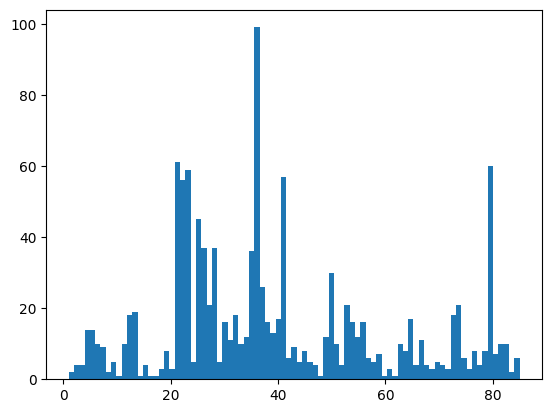

In [ ]:
#Optional - see how many clusters are generated from matrix and the number of observations per cluster:
plt.hist(T,bins=len(np.unique(T)))

In [ ]:
#Function for splitting arrays based on order of another array. Here, indices in T correspond to those of N neurons and elements are class number,
#so we can use the indexing in T to split our other arrays.

def groupby(a, b):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = b.argsort(kind='mergesort')
    a_sorted = a[sidx]
    b_sorted = b[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,b_sorted[1:] != b_sorted[:-1],True])

    # Split input array with those start, stop ones
    out = [a_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return out

In [ ]:
#For grouping and concatenating the cell array
cell_arr_sorted = groupby(cell_array,T)

cell_arr_sorted_concat = np.concatenate((cell_arr_sorted))

In [ ]:
#Run the following code blocks if you are using n284xn283 fish:

In [ ]:
#For grouping the score arrays

pt_left_score_i_all_sorted = groupby(pt_left_score_i_all,T)
pt_left_m_score_i_all_sorted = groupby(pt_left_m_score_i_all,T)
pt_left_l_score_i_all_sorted = groupby(pt_left_l_score_i_all,T)
pt_right_score_i_all_sorted = groupby(pt_right_score_i_all,T)
pt_right_m_score_i_all_sorted = groupby(pt_right_m_score_i_all,T)
pt_right_l_score_i_all_sorted = groupby(pt_right_l_score_i_all,T)
pt_iwd_score_i_all_sorted = groupby(pt_iwd_score_i_all,T)
pt_owd_score_i_all_sorted = groupby(pt_owd_score_i_all,T)
pt_fwd_score_i_all_sorted = groupby(pt_fwd_score_i_all,T)
pt_fwd_x_score_i_all_sorted = groupby(pt_fwd_x_score_i_all,T)
pt_x_fwd_score_i_all_sorted = groupby(pt_x_fwd_score_i_all,T)
pt_bwd_score_i_all_sorted = groupby(pt_bwd_score_i_all,T)
pt_bwd_x_score_i_all_sorted = groupby(pt_bwd_x_score_i_all,T)
pt_x_bwd_score_i_all_sorted = groupby(pt_x_bwd_score_i_all,T)
pt_fwd_bwd_score_i_all_sorted = groupby(pt_fwd_bwd_score_i_all,T)
pt_bwd_fwd_score_i_all_sorted = groupby(pt_bwd_fwd_score_i_all,T)

In [ ]:
#For finding the counts of responsiveness to stimuli within each cluster
pt_left_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_score_i_all_counts[i] = len(np.nonzero(pt_left_score_i_all_sorted[i])[0])/len(pt_left_score_i_all_sorted[i])
pt_left_m_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_m_score_i_all_counts[i] = len(np.nonzero(pt_left_m_score_i_all_sorted[i])[0])/len(pt_left_m_score_i_all_sorted[i])
pt_left_l_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_l_score_i_all_counts[i] = len(np.nonzero(pt_left_l_score_i_all_sorted[i])[0])/len(pt_left_l_score_i_all_sorted[i])
pt_right_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_score_i_all_counts[i] = len(np.nonzero(pt_right_score_i_all_sorted[i])[0])/len(pt_right_score_i_all_sorted[i])
pt_right_m_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_m_score_i_all_counts[i] = len(np.nonzero(pt_right_m_score_i_all_sorted[i])[0])/len(pt_right_m_score_i_all_sorted[i])
pt_right_l_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_l_score_i_all_counts[i] = len(np.nonzero(pt_right_l_score_i_all_sorted[i])[0])/len(pt_right_l_score_i_all_sorted[i])
pt_iwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_iwd_score_i_all_counts[i] = len(np.nonzero(pt_iwd_score_i_all_sorted[i])[0])/len(pt_iwd_score_i_all_sorted[i])
pt_owd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_owd_score_i_all_counts[i] = len(np.nonzero(pt_owd_score_i_all_sorted[i])[0])/len(pt_owd_score_i_all_sorted[i])
pt_fwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_score_i_all_counts[i] = len(np.nonzero(pt_fwd_score_i_all_sorted[i])[0])/len(pt_fwd_score_i_all_sorted[i])
pt_fwd_x_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_x_score_i_all_counts[i] = len(np.nonzero(pt_fwd_x_score_i_all_sorted[i])[0])/len(pt_fwd_x_score_i_all_sorted[i])
pt_x_fwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_x_fwd_score_i_all_counts[i] = len(np.nonzero(pt_x_fwd_score_i_all_sorted[i])[0])/len(pt_x_fwd_score_i_all_sorted[i])
pt_bwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_score_i_all_counts[i] = len(np.nonzero(pt_bwd_score_i_all_sorted[i])[0])/len(pt_bwd_score_i_all_sorted[i])
pt_bwd_x_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_x_score_i_all_counts[i] = len(np.nonzero(pt_bwd_x_score_i_all_sorted[i])[0])/len(pt_bwd_x_score_i_all_sorted[i])
pt_x_bwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_x_bwd_score_i_all_counts[i] = len(np.nonzero(pt_x_bwd_score_i_all_sorted[i])[0])/len(pt_x_bwd_score_i_all_sorted[i])
pt_fwd_bwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_bwd_score_i_all_counts[i] = len(np.nonzero(pt_fwd_bwd_score_i_all_sorted[i])[0])/len(pt_fwd_bwd_score_i_all_sorted[i])
pt_bwd_fwd_score_i_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_fwd_score_i_all_counts[i] = len(np.nonzero(pt_bwd_fwd_score_i_all_sorted[i])[0])/len(pt_bwd_fwd_score_i_all_sorted[i])

In [ ]:
#putting the counts into an array

pt_stim_score_counts = [pt_iwd_score_i_all_counts,pt_owd_score_i_all_counts,pt_left_score_i_all_counts,
                        pt_left_m_score_i_all_counts,pt_left_l_score_i_all_counts, pt_right_score_i_all_counts,
                        pt_right_m_score_i_all_counts,pt_right_l_score_i_all_counts,pt_fwd_score_i_all_counts,
                       pt_fwd_x_score_i_all_counts,pt_x_fwd_score_i_all_counts,pt_bwd_score_i_all_counts,
                       pt_bwd_x_score_i_all_counts,pt_x_bwd_score_i_all_counts,pt_fwd_bwd_score_i_all_counts,
                       pt_bwd_fwd_score_i_all_counts]

In [ ]:
#Run the following code blocks if using n277xn283 fish

In [ ]:
#For grouping the stimulus responsiveness scores by cluster
pt_left_score_e_all_sorted = groupby(pt_left_score_e_all,T)
pt_left_m_score_e_all_sorted = groupby(pt_left_m_score_e_all,T)
pt_left_l_score_e_all_sorted = groupby(pt_left_l_score_e_all,T)
pt_right_score_e_all_sorted = groupby(pt_right_score_e_all,T)
pt_right_m_score_e_all_sorted = groupby(pt_right_m_score_e_all,T)
pt_right_l_score_e_all_sorted = groupby(pt_right_l_score_e_all,T)
pt_iwd_score_e_all_sorted = groupby(pt_iwd_score_e_all,T)
pt_owd_score_e_all_sorted = groupby(pt_owd_score_e_all,T)
pt_fwd_score_e_all_sorted = groupby(pt_fwd_score_e_all,T)
pt_fwd_x_score_e_all_sorted = groupby(pt_fwd_x_score_e_all,T)
pt_x_fwd_score_e_all_sorted = groupby(pt_x_fwd_score_e_all,T)
pt_bwd_score_e_all_sorted = groupby(pt_bwd_score_e_all,T)
pt_bwd_x_score_e_all_sorted = groupby(pt_bwd_x_score_e_all,T)
pt_x_bwd_score_e_all_sorted = groupby(pt_x_bwd_score_e_all,T)
pt_fwd_bwd_score_e_all_sorted = groupby(pt_fwd_bwd_score_e_all,T)
pt_bwd_fwd_score_e_all_sorted = groupby(pt_bwd_fwd_score_e_all,T)

NameError: ignored

In [ ]:
#For determining stimulus responsiveness counts per cluster

pt_left_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_score_e_all_counts[i] = len(np.nonzero(pt_left_score_e_all_sorted[i])[0])/len(pt_left_score_e_all_sorted[i])
pt_left_m_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_m_score_e_all_counts[i] = len(np.nonzero(pt_left_m_score_e_all_sorted[i])[0])/len(pt_left_m_score_e_all_sorted[i])
pt_left_l_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_left_l_score_e_all_counts[i] = len(np.nonzero(pt_left_l_score_e_all_sorted[i])[0])/len(pt_left_l_score_e_all_sorted[i])
pt_right_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_score_e_all_counts[i] = len(np.nonzero(pt_right_score_e_all_sorted[i])[0])/len(pt_right_score_e_all_sorted[i])
pt_right_m_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_m_score_e_all_counts[i] = len(np.nonzero(pt_right_m_score_e_all_sorted[i])[0])/len(pt_right_m_score_e_all_sorted[i])
pt_right_l_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_right_l_score_e_all_counts[i] = len(np.nonzero(pt_right_l_score_e_all_sorted[i])[0])/len(pt_right_l_score_e_all_sorted[i])
pt_iwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_iwd_score_e_all_counts[i] = len(np.nonzero(pt_iwd_score_e_all_sorted[i])[0])/len(pt_iwd_score_e_all_sorted[i])
pt_owd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_owd_score_e_all_counts[i] = len(np.nonzero(pt_owd_score_e_all_sorted[i])[0])/len(pt_owd_score_e_all_sorted[i])
pt_fwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_score_e_all_counts[i] = len(np.nonzero(pt_fwd_score_e_all_sorted[i])[0])/len(pt_fwd_score_e_all_sorted[i])
pt_fwd_x_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_x_score_e_all_counts[i] = len(np.nonzero(pt_fwd_x_score_e_all_sorted[i])[0])/len(pt_fwd_x_score_e_all_sorted[i])
pt_x_fwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_x_fwd_score_e_all_counts[i] = len(np.nonzero(pt_x_fwd_score_e_all_sorted[i])[0])/len(pt_x_fwd_score_e_all_sorted[i])
pt_bwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_score_e_all_counts[i] = len(np.nonzero(pt_bwd_score_e_all_sorted[i])[0])/len(pt_bwd_score_e_all_sorted[i])
pt_bwd_x_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_x_score_e_all_counts[i] = len(np.nonzero(pt_bwd_x_score_e_all_sorted[i])[0])/len(pt_bwd_x_score_e_all_sorted[i])
pt_x_bwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_x_bwd_score_e_all_counts[i] = len(np.nonzero(pt_x_bwd_score_e_all_sorted[i])[0])/len(pt_x_bwd_score_e_all_sorted[i])
pt_fwd_bwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_fwd_bwd_score_e_all_counts[i] = len(np.nonzero(pt_fwd_bwd_score_e_all_sorted[i])[0])/len(pt_fwd_bwd_score_e_all_sorted[i])
pt_bwd_fwd_score_e_all_counts = np.zeros(len(np.unique(T)))
for i in np.arange(len(np.unique(T))):
    pt_bwd_fwd_score_e_all_counts[i] = len(np.nonzero(pt_bwd_fwd_score_e_all_sorted[i])[0])/len(pt_bwd_fwd_score_e_all_sorted[i])

In [ ]:
#Putting the cluster counts in an array
pt_stim_score_counts = [pt_iwd_score_e_all_counts,pt_owd_score_e_all_counts,pt_left_score_e_all_counts,
                        pt_left_m_score_e_all_counts,pt_left_l_score_e_all_counts, pt_right_score_e_all_counts,
                        pt_right_m_score_e_all_counts,pt_right_l_score_e_all_counts,pt_fwd_score_e_all_counts,
                       pt_fwd_x_score_e_all_counts,pt_x_fwd_score_e_all_counts,pt_bwd_score_e_all_counts,
                       pt_bwd_x_score_e_all_counts,pt_x_bwd_score_e_all_counts,pt_fwd_bwd_score_e_all_counts,
                       pt_bwd_fwd_score_e_all_counts]

In [ ]:
#Run following blocks for all fish

In [ ]:
#For determining the frequency of responsiveness to stimuli per class
class_stim_freq = np.zeros((len(np.unique(T)),n_stim))
for i in np.arange(len(np.unique(T))):
    for j in np.arange(n_stim):
        class_stim_freq[i][j] = pt_stim_score_counts[j][i]

In [ ]:
#This is used for visualization purposes
x_omit = np.zeros((10))
x_omit1 = np.array([0,20])
x_omit2 = np.array([0+21,20+21])
x_omit3 = np.array([0+21*2,20+21*2])
x_omit4 = np.array([0+21*3,20+21*3])
x_omit5 = np.array([0+21*4,20+21*4])
x_omit6 = np.array([0+21*5,20+21*5])
x_omit7 = np.array([0+21*6,20+21*6])
x_omit8 = np.array([0+21*7,20+21*7])
x_omit9 = np.array([0+21*8,20+21*8])
x_omit10 = np.array([0+21*9,20+21*9])
x_omit11 = np.array([0+21*10,20+21*10])
x_omit12 = np.array([0+21*11,20+21*11])
x_omit13 = np.array([0+21*12,20+21*12])
x_omit14 = np.array([0+21*13,20+21*13])
x_omit15 = np.array([0+21*14,20+21*14])
x_omit16 = np.array([0+21*15,20+21*15])
x_omit = np.concatenate((x_omit1,x_omit2,x_omit3,x_omit4,x_omit5,x_omit6,x_omit7,x_omit8,x_omit9,x_omit10,x_omit11,x_omit12,x_omit13,x_omit14,x_omit15,x_omit16))

In [ ]:
#Computing summary stats of the different clusters - used for visualization purposes later

class_index = 0
o_t_mean = np.zeros((len(np.unique(T)),21*n_stim))
o_t_sem = np.zeros((len(np.unique(T)),21*n_stim))

for i in np.arange(len(cell_arr_sorted)):
    overlay_traces_mean = cell_arr_sorted[i].mean(axis=0)
    overlay_traces_std = cell_arr_sorted[i].std(axis=0)
    overlay_traces_sem = overlay_traces_std / np.sqrt(len(cell_arr_sorted[i]))

    overlay_traces_mean_mask = np.zeros((len(overlay_traces_mean)))
    overlay_traces_sem_mask = np.zeros((len(overlay_traces_sem)))
    for j in np.arange(len(overlay_traces_mean)):
        overlay_traces_mean_mask[j] = overlay_traces_mean[j]
        overlay_traces_sem_mask[j] = overlay_traces_sem[j]
    for j in x_omit:
        overlay_traces_mean_mask[j] = None
        overlay_traces_sem_mask[j] = None
    for j in np.arange(21*n_stim):
        o_t_mean[i][j] = overlay_traces_mean_mask[j]
        o_t_sem[i][j] = overlay_traces_sem_mask[j]

In [ ]:
#For generating names of classes. Mostly for visualization purposes - it lists class number and neuron count
class_names = ["" for x in range(len(np.unique(T)))]
for i in np.arange(len(np.unique(T))):
    class_names[i] = f'class_{i} count_{test_counts[i]}'

In [ ]:
#Following are for visualizing classes

<ipython-input-103-e7506da8b747>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Set1')  # type: matplotlib.colors.ListedColormap


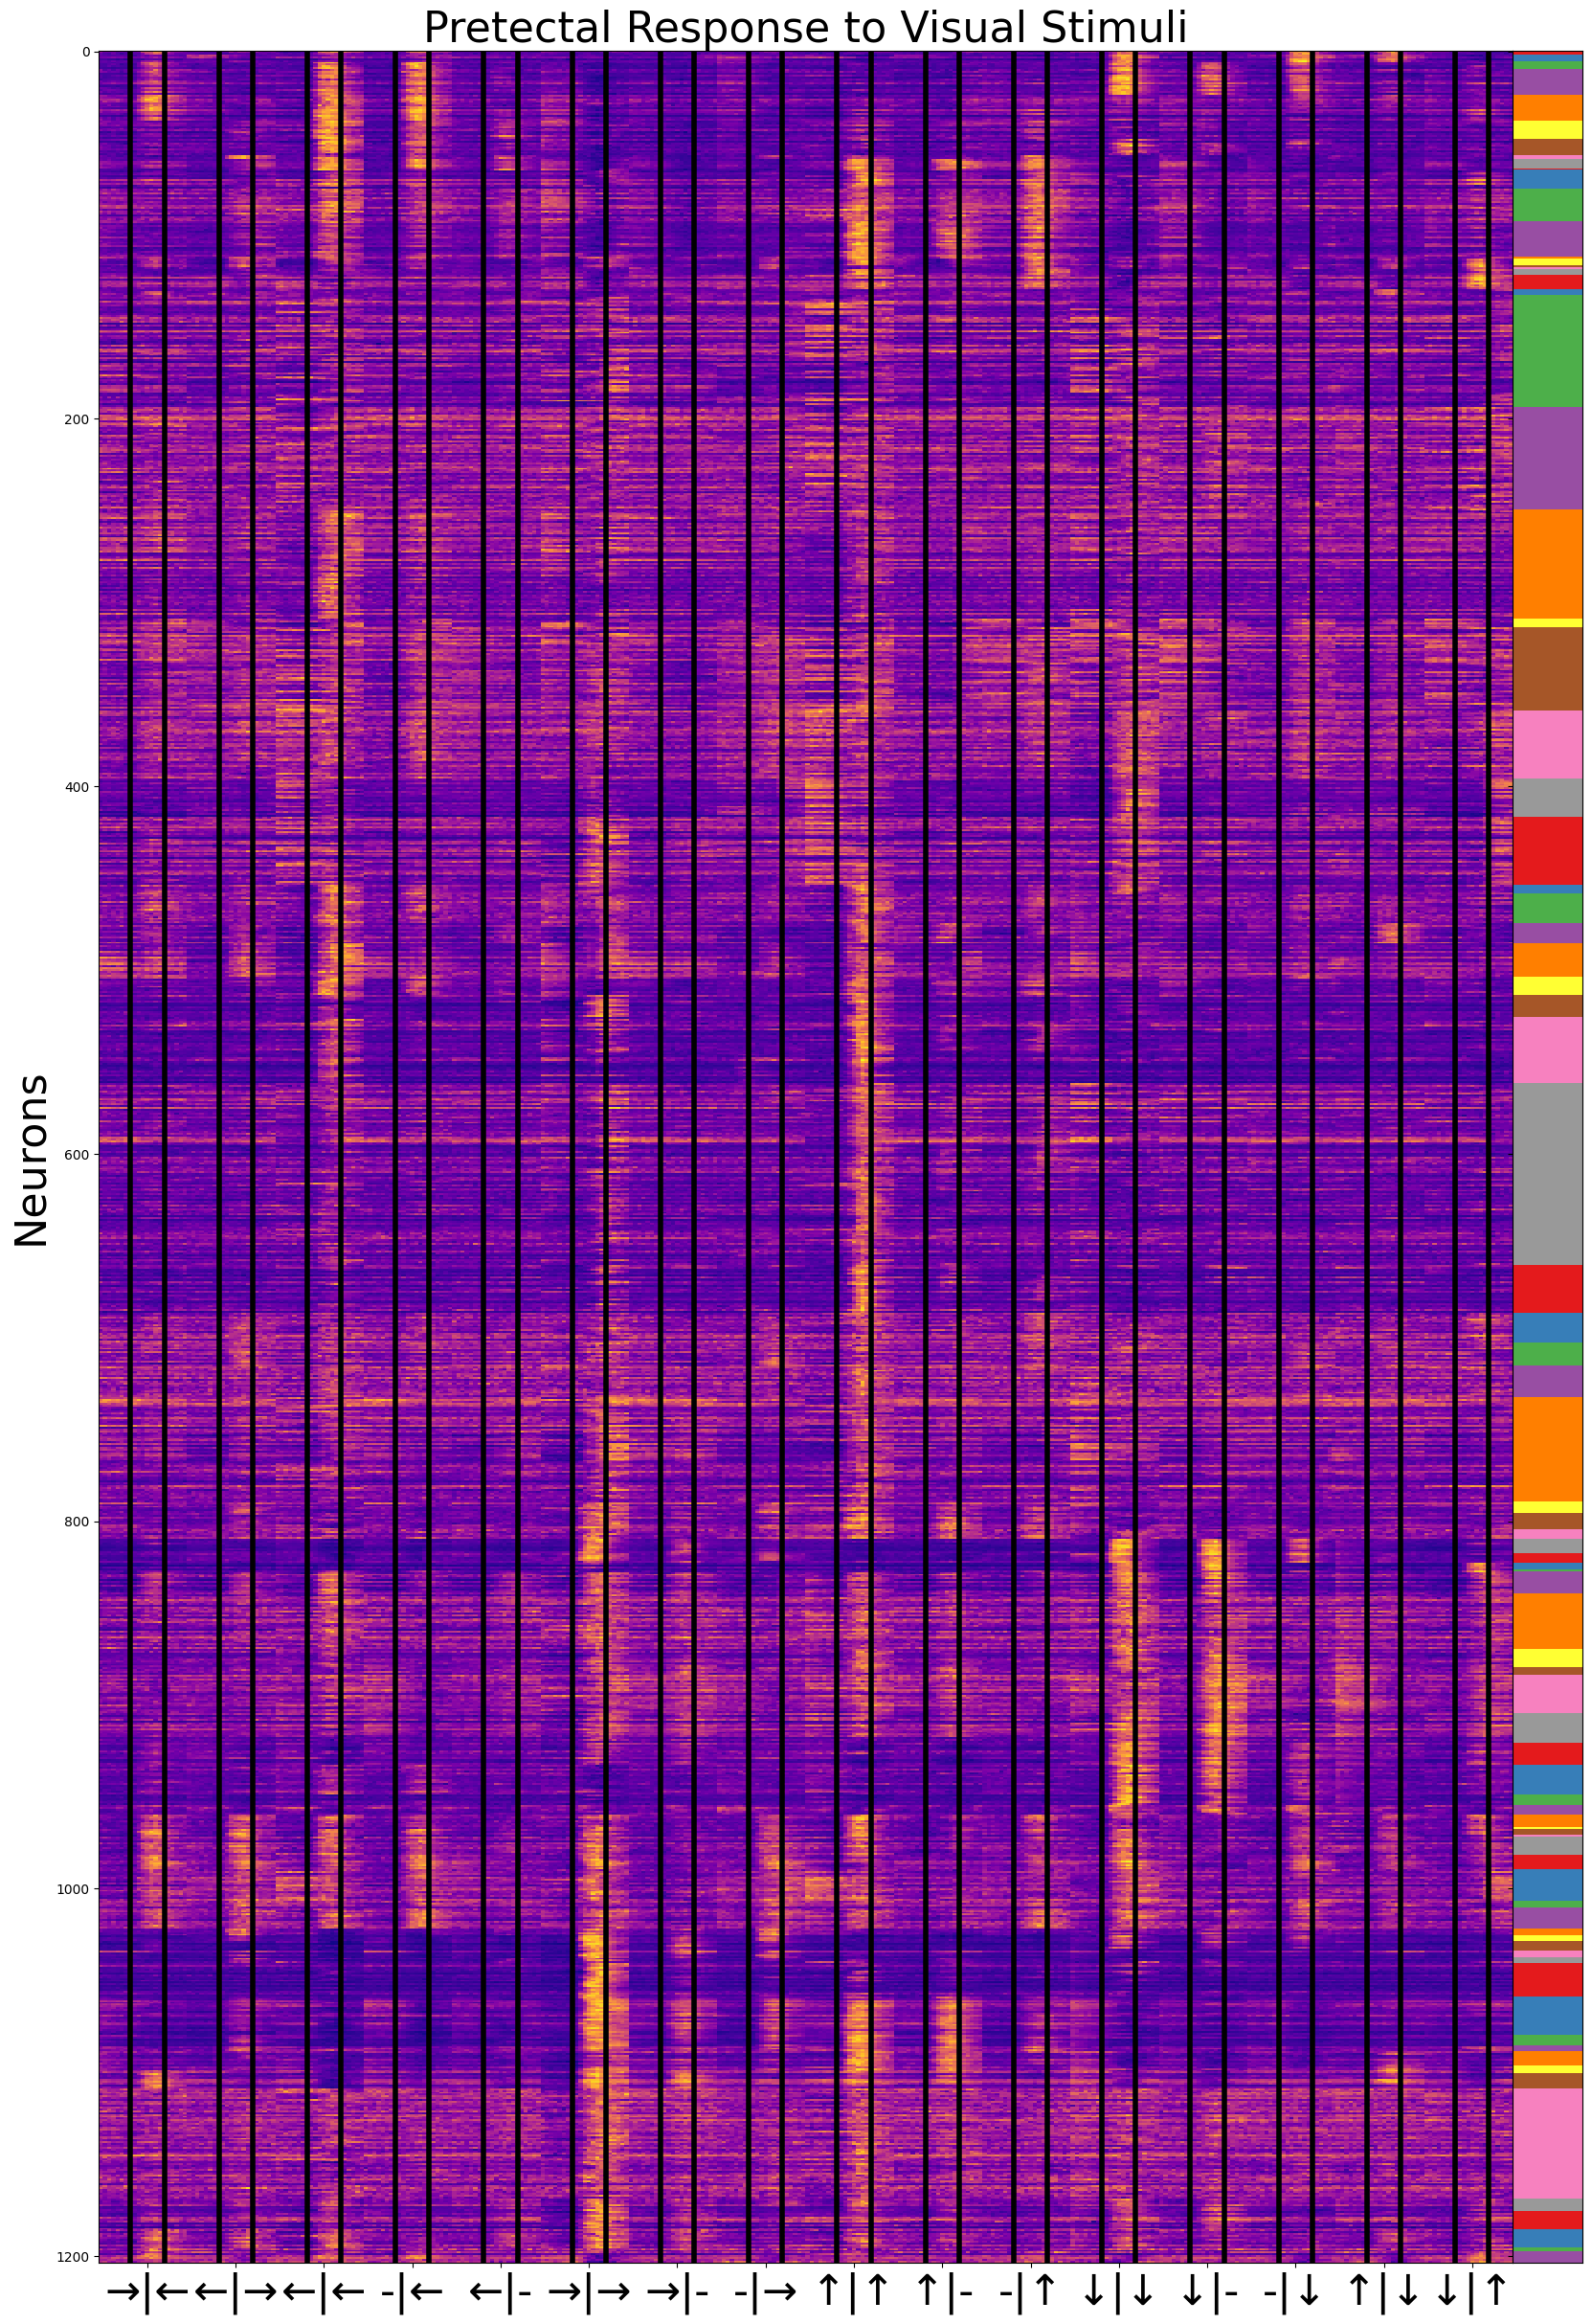

In [ ]:
#This makes a heatmap of all neurons in the array and draws gridlines for the on-periods of stimuli. There is a colorbar to the right which
#represents the neurons in each class. The thickness of each color band is related to how many neurons are in a given class.


from matplotlib.cm import get_cmap
from matplotlib import gridspec

#fig = plt.figure(figsize=(50, 10))
#gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], height_ratios=[1])
#ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [20, 1]}, figsize=(20, 30))

#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, width_ratios=[20, 1], height_ratios=[1], figsize=(20, 10))
ax1.imshow(cell_arr_sorted_concat, cmap='plasma', interpolation='nearest', aspect='auto')
#ax1.title.set_text('Pretectal Response to Visual Stimuli')
ax1.set_title('Pretectal Response to Visual Stimuli',fontsize=32)
ax1.set_ylabel('Neurons', fontsize=32)
ax1.set_xticks([11, 11+21, 11+21*2, 11+21*3, 11+21*4,11+21*5,11+21*6,11+21*7,11+21*8,11+21*9,11+21*10,11+21*11,11+21*12,11+21*13,11+21*14,11+21*15])
ax1.set_xticklabels(['→|←','←|→','←|←','-|←','←|-','→|→','→|-','-|→','↑|↑','↑|-','-|↑','↓|↓','↓|-','-|↓','↑|↓','↓|↑'], fontsize = 32)
ax2.set_xticks([])

x_start = 7
x_stop = 15

#ax1.axvspan(x_start,x_stop, color='yellow', alpha=0.4, lw=0)
for i in np.arange(16):
    ax1.vlines(x_start, -0.5, len(cell_arr_sorted_concat)-0.5, color='black',linewidth=4)
    ax1.vlines(x_stop, -0.5, len(cell_arr_sorted_concat)-0.5, color='black',linewidth=4)
    x_start = 21 + x_start
    x_stop = 21 + x_stop

bottom = -0.5  # y-coordinates of the bottom side of the bar
x = 0
width = 0.5

cmap = get_cmap('Set1')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
ax2.set_prop_cycle(color=colors)

test_arange_array = np.arange(len(cell_arr_sorted))

for i in np.arange(len(cell_arr_sorted)):
    p = ax2.bar(x, len(cell_arr_sorted[i]),width,label=class_names[i],bottom=bottom)
    if i < test_arange_array[-1]:
        bottom += len(cell_arr_sorted[i])

    #ax2.bar_label(p, labels=[class_names[i]], label_type='center')
#for cluster, temps in sorted_clusters.items():
#    p = ax2.bar(x, len(temps), width, label=str(cluster), bottom=bottom)
#    bottom += len(temps)
#
#    ax2.bar_label(p, labels=[str(cluster)], label_type='center')

plt.subplots_adjust(wspace=0,hspace=0)
ax1.margins(x=0)
ax1.margins(y=0)
ax2.margins(x=0)
ax2.margins(y=0)

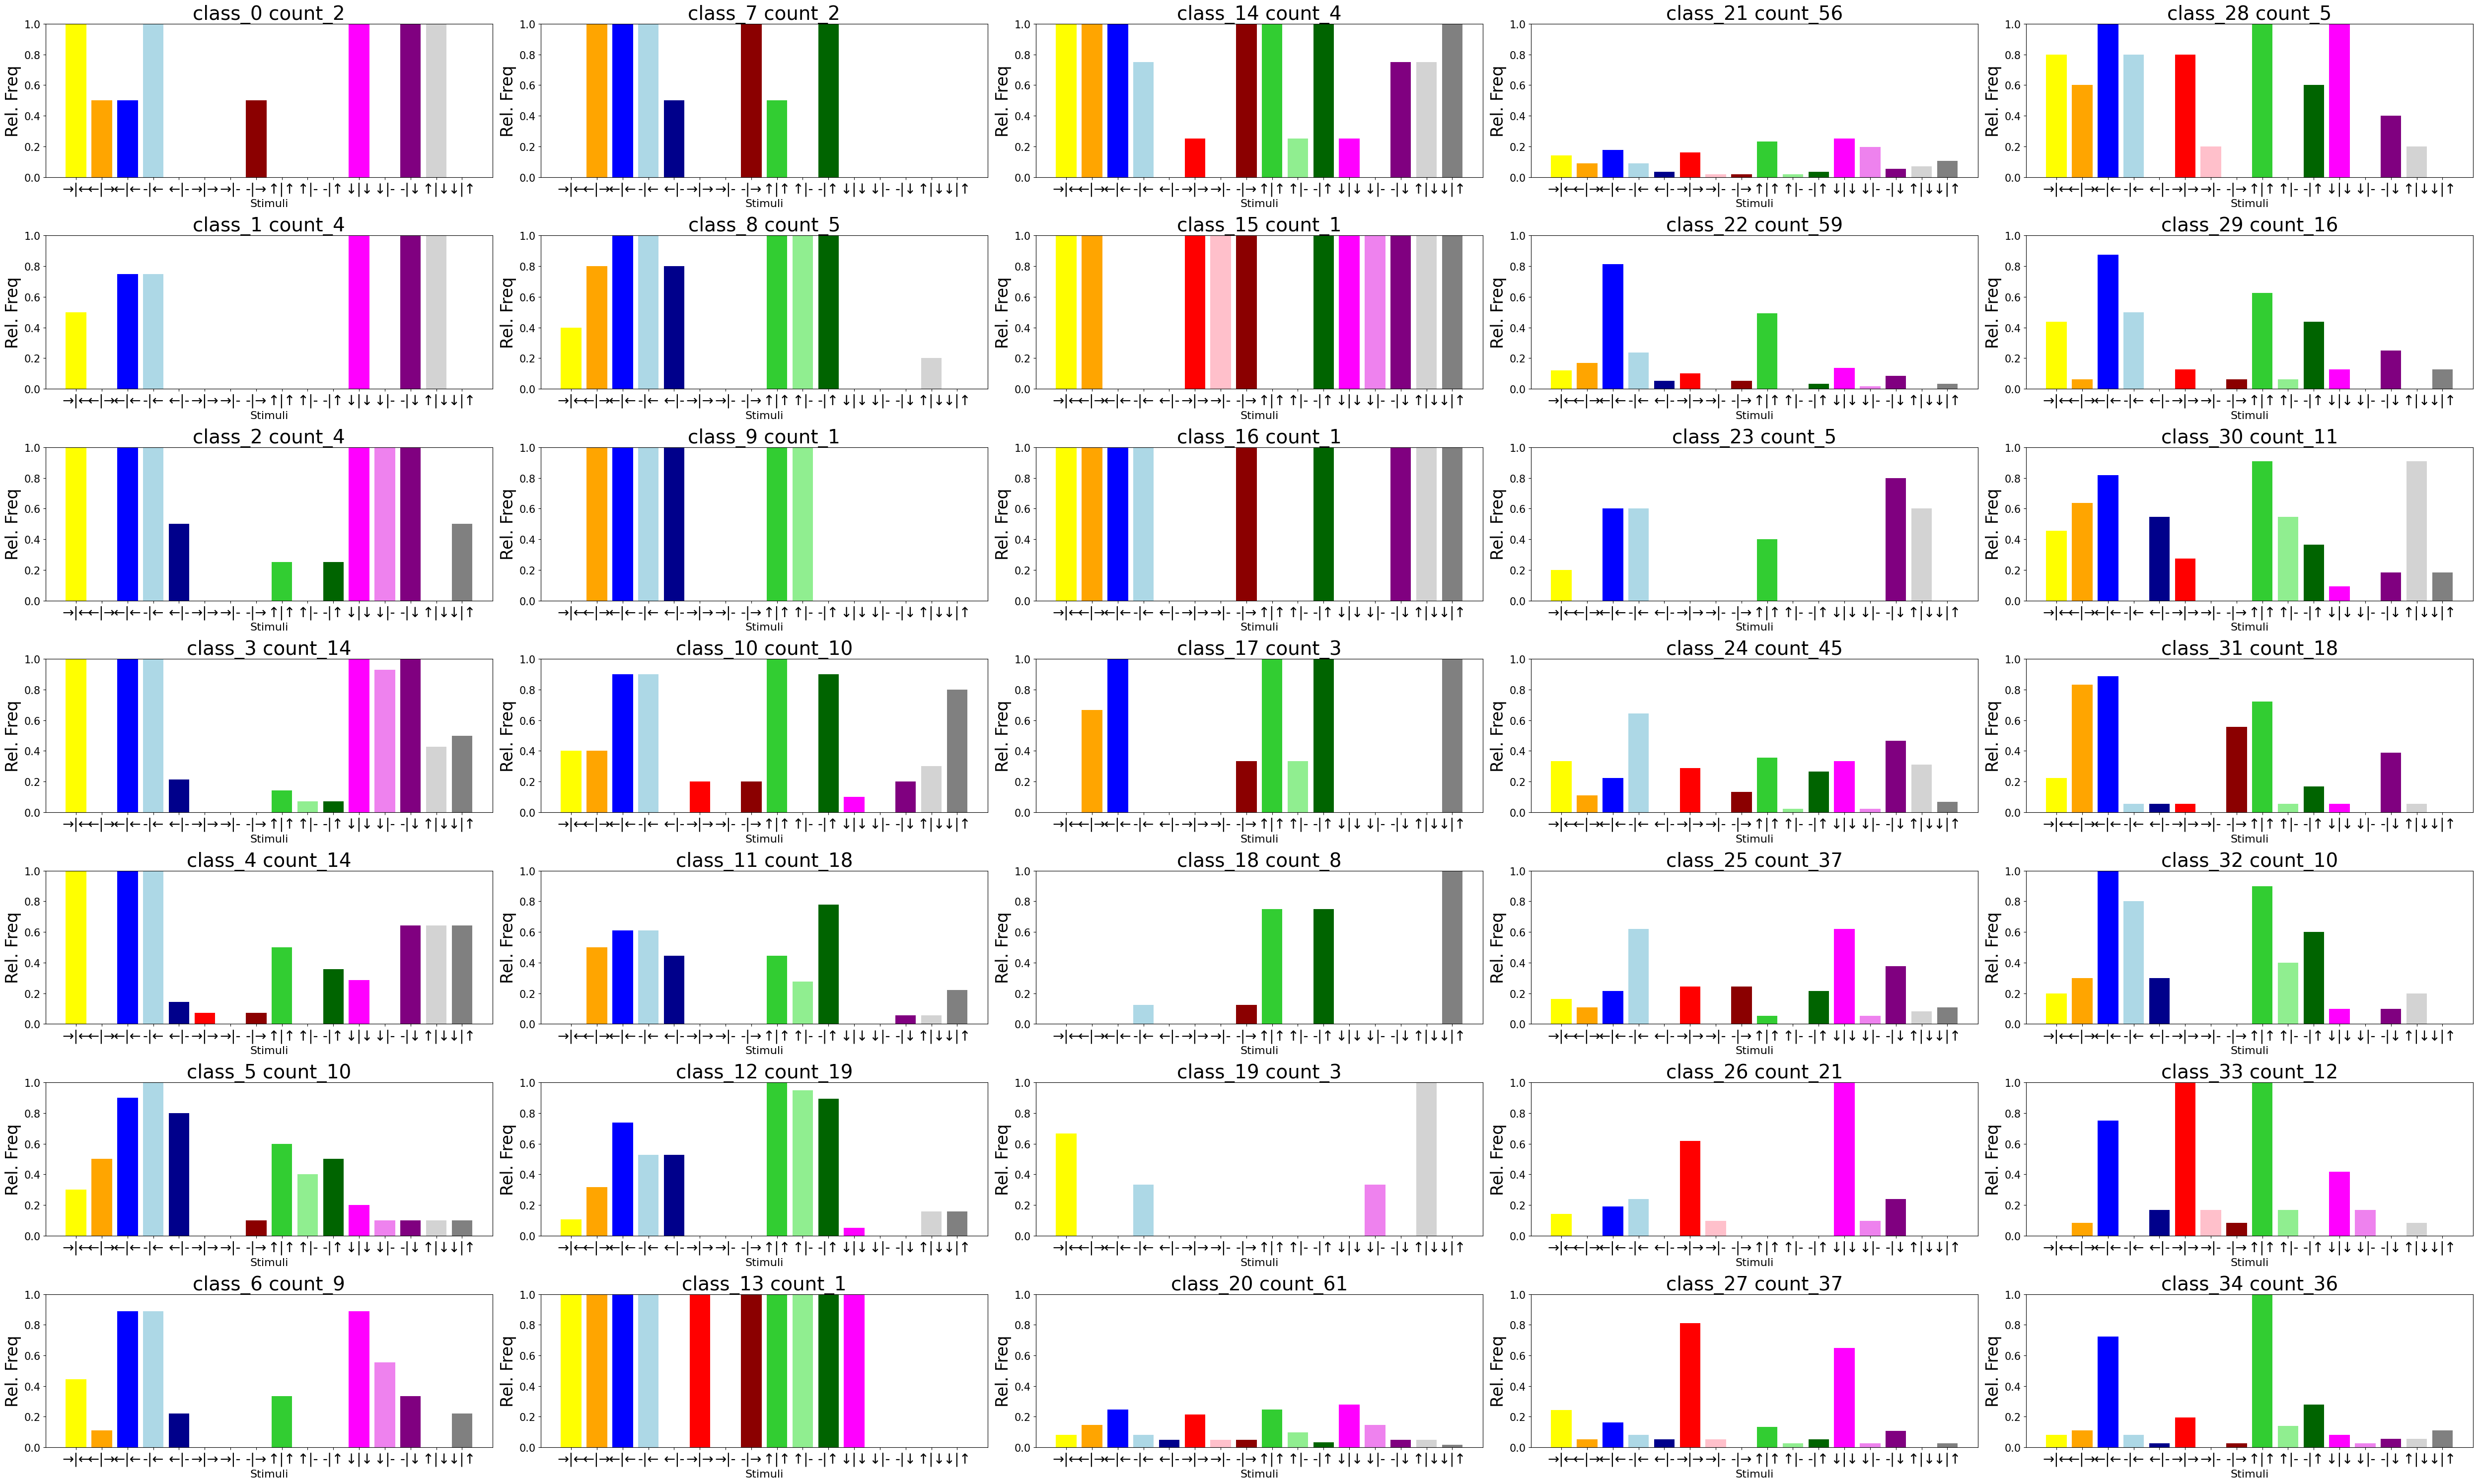

In [ ]:
#For visualizing how many neurons are responsive to the stimuli in a given class. Note, counter is used for the starting neuron. How this is
#currently set up is there are 35 panels of traces. If you have fewer than 35 classes, you'll want to edit the figsize and number of rows and
#columns. I find 35 is a good balance of a high number of traces while still being large enough to visualize differences. In general, you'll
#want to see classes where there are neurons responsive to specific stimulus combinations. You want to see some classes with higher frequencies
#and others with lower frequencies. Generally, these are the more interesting classes. The classes with the most neurons usually are those that
#have neurons responding to most stimuli and are typically uninteresting. You want your parameters to maximize the number of interesting classes.

import matplotlib.pyplot as plt

fig, a = plt.subplots(7,5, figsize=(50, 30))
counter = 0
for j in np.arange(5):
    for i in np.arange(7):

        a[i][j].set_title(class_names[counter],fontsize=28)

        a[i][j].bar(np.arange(n_stim),class_stim_freq[counter],color=['yellow', 'orange', 'blue', 'lightblue', 'darkblue', 'red', 'pink', 'darkred','limegreen','lightgreen','darkgreen','magenta','violet','purple','lightgrey','grey'])

        ax = plt.gca()

        #hide x-axis
        fig.canvas.draw()

        #a[i][j].set_xticks([11, 11+21, 11+21*2, 11+21*3, 11+21*4,11+21*5,11+21*6,11+21*7])
        #a[i][j].set_xticklabels(['→|←','←|→','←|←','-|←','←|-','→|→','→|-','-|→'], fontsize = 20)
        #ax.get_xaxis().set_visible(False)
        a[i][j].set_xlabel('Stimuli',fontsize=16)
        a[i][j].set_ylabel('Rel. Freq', fontsize=24)
        a[i][j].tick_params(axis='both', which='major', labelsize=15)
        a[i][j].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
        a[i][j].set_xticklabels(['→|←','←|→','←|←','-|←','←|-','→|→','→|-','-|→','↑|↑','↑|-','-|↑','↓|↓','↓|-','-|↓','↑|↓','↓|↑'], fontsize = 20)
        counter = counter + 1
        #a[i][j].set_xticks(np.arange(len(np.unique(T))))
        #a[i][j].set_xticks(np.arange(len(np.unique(T))),fontsize=20)
        #a[i][j].set_yticks(pt_barcode_counts[j][i],fontsize=20)
        #hide y-axis
        #ax.get_yaxis().set_visible(False)

        #ax.xaxis.set_tick_params(labelbottom=False)
        #a[i][j].yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        #ax.set_xticks([])
        #a[i][j].set_yticks([])


        a[i][j].set_ylim([0, 1])

fig.tight_layout()
plt.rcParams["figure.figsize"] = (30,50)
plt.show()

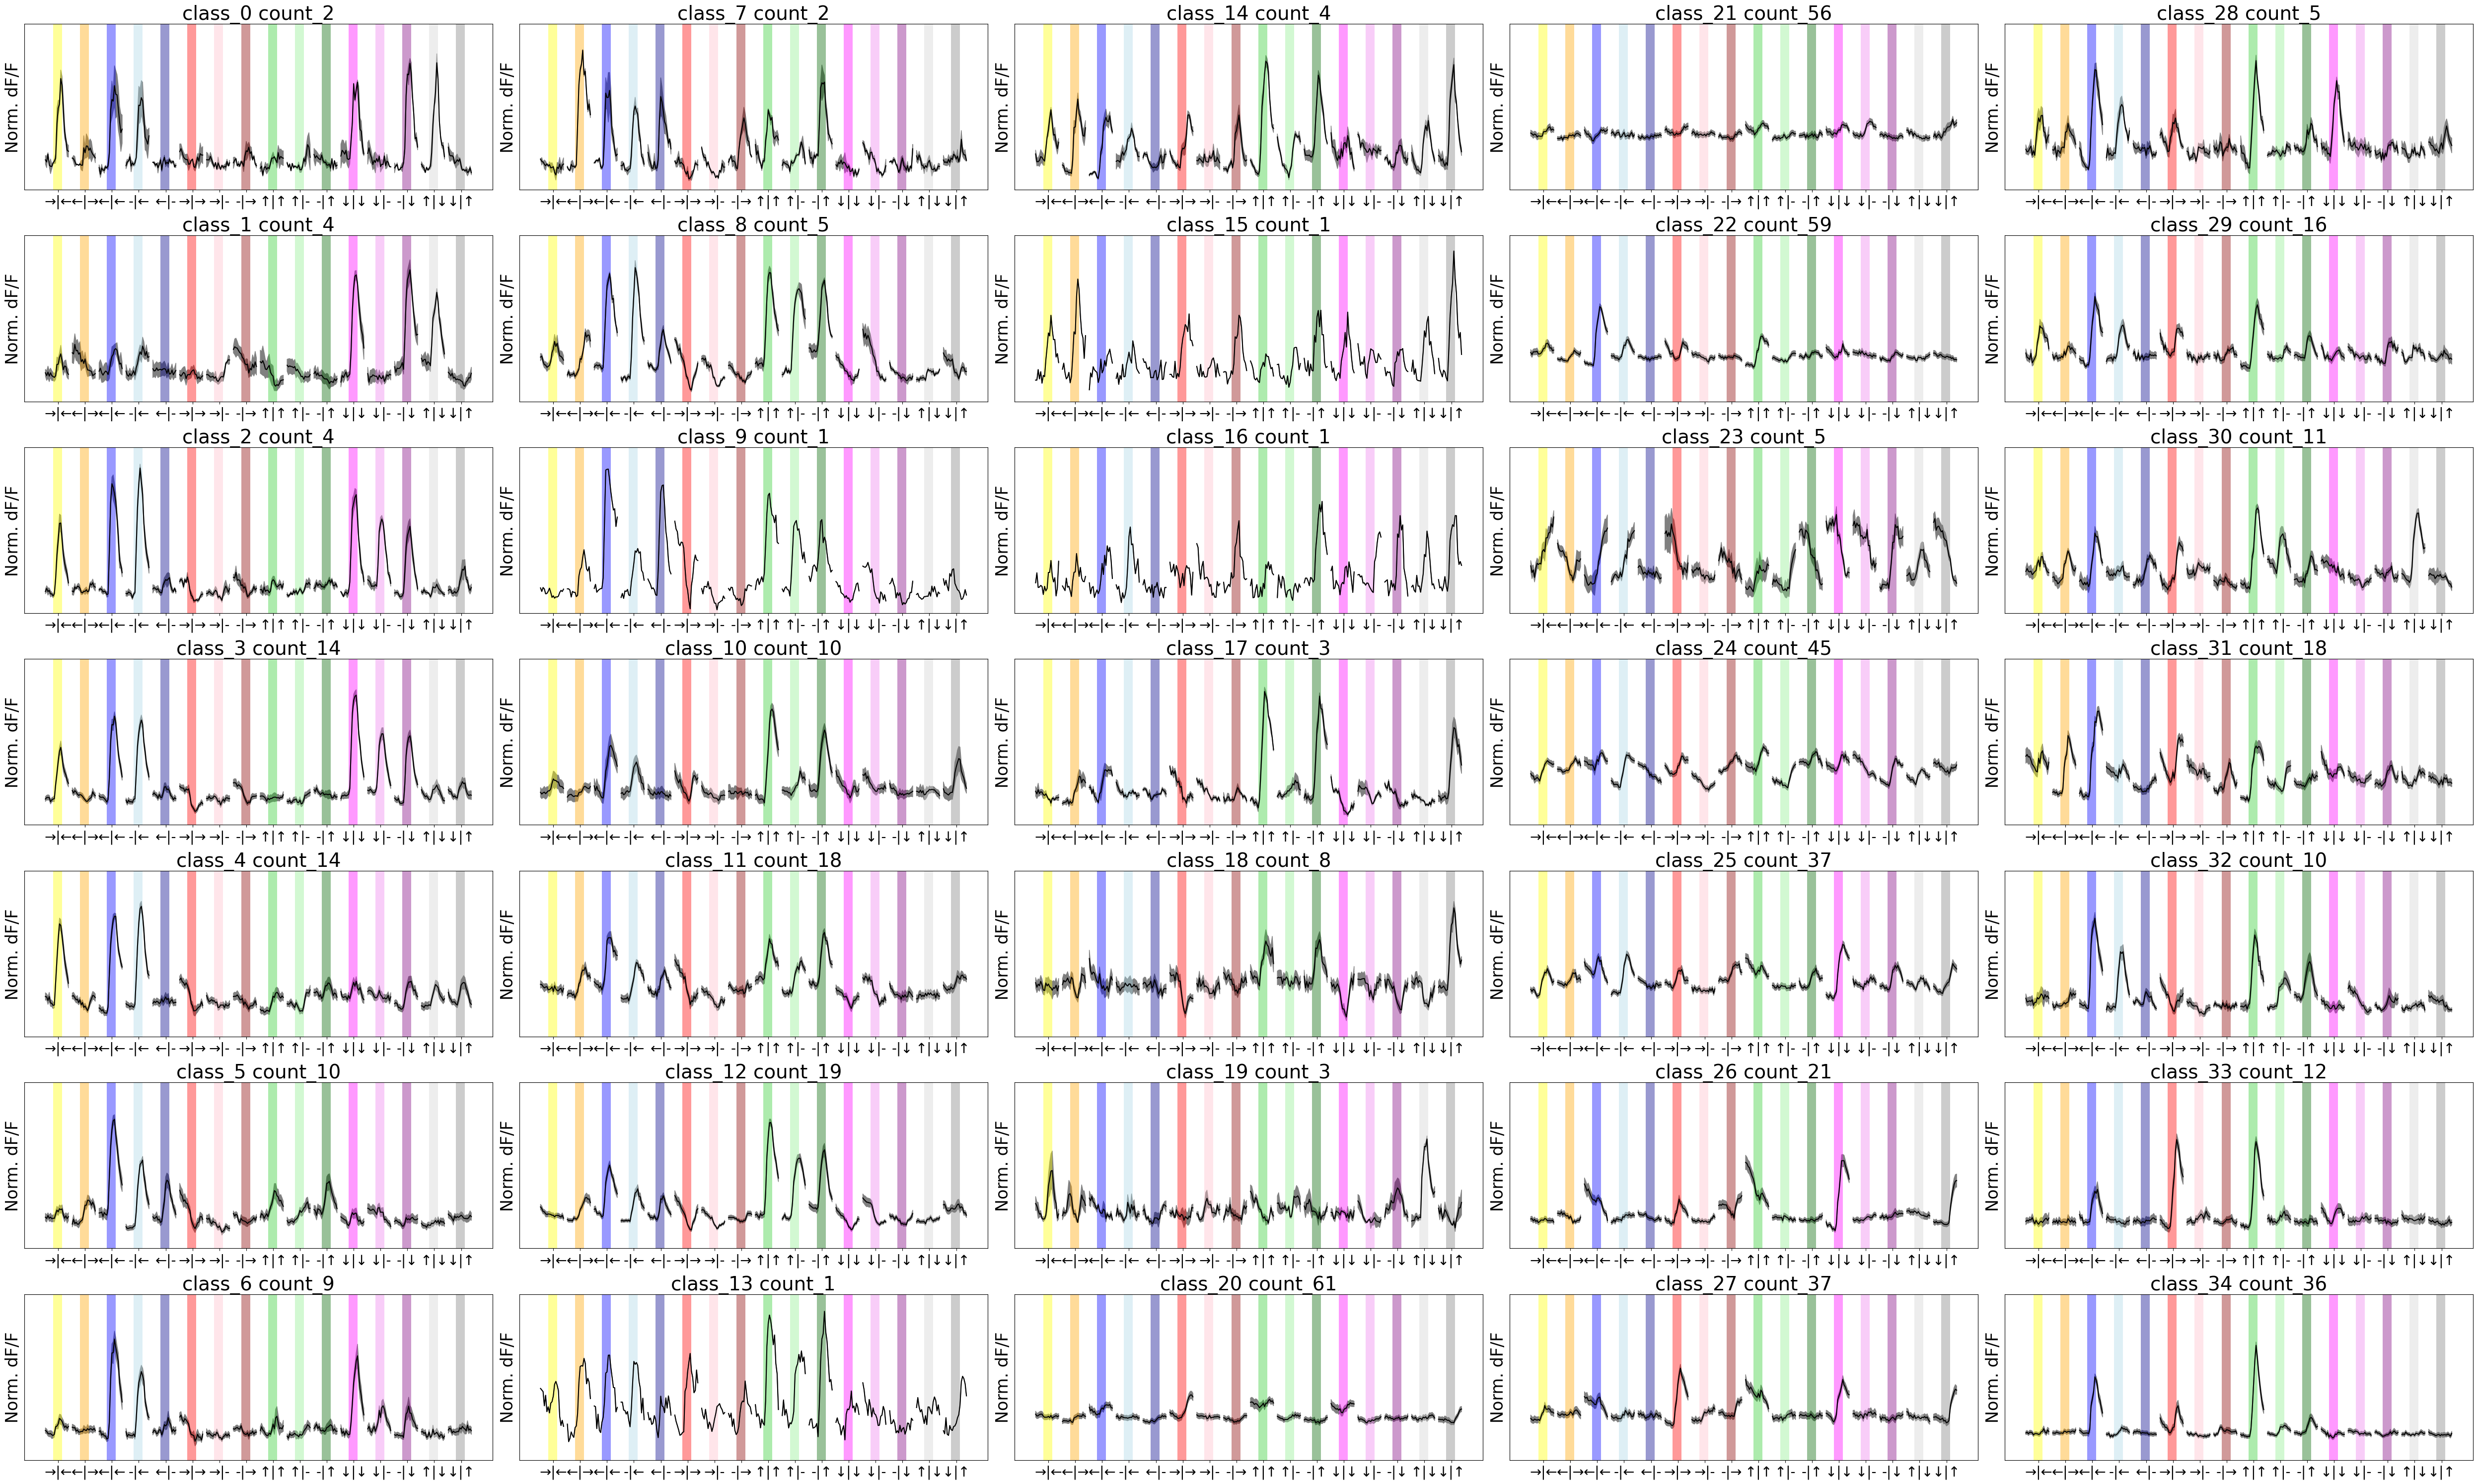

In [ ]:
#For visualizing the average traces for each class. It is similar in format to the visualization above. As before, you'll want to observe
#classes highly responsive to some stimuli but not others. Also, you'll want to see some classes also be suppressed to some stimuli, which you'll
#see when their traces actually go down during stimulus on period.

import matplotlib.pyplot as plt
#fig, a = plt.subplots(2,5, figsize=(50, 10))
fig, a = plt.subplots(7,5, figsize=(50, 30))

counter = 0

#for j in np.arange(5):
    #for i in np.arange(2):
for j in np.arange(5):
    for i in np.arange(7):

        a[i][j].set_title(class_names[counter],fontsize=28)

        x_start = 7
        x_stop = 14

        a[i][j].plot(np.arange(len(o_t_mean[counter])),o_t_mean[counter],color='black')

        y_low = o_t_mean[counter]-o_t_sem[counter]
        y_high = o_t_mean[counter]+o_t_sem[counter]
        x_range = np.arange(len(o_t_mean[counter]))

        counter = counter +1

        a[i][j].fill_between(x_range,y_low,y_high,color='gray')

        a[i][j].axvspan(x_start,x_stop, color='yellow', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='orange', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='blue', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='lightblue', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='darkblue', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='red', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='pink', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='darkred', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='limegreen', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='lightgreen', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='darkgreen', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='magenta', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='violet', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='purple', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='lightgrey', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop
        a[i][j].axvspan(x_start,x_stop, color='grey', alpha=0.4, lw=0)
        x_start = 21 + x_start
        x_stop = 21 + x_stop

        ax = plt.gca()

        #hide x-axis
        fig.canvas.draw()

        #labels = [item.get_text() for item in ax.get_xticklabels()]
        #labels = ["" for x in range(len(overlay_traces_mean_mask))]
        #for i in x_range:
        #    labels[i] = ''
        #labels[10] = 'Testing'
        a[i][j].set_xticks([11, 11+21, 11+21*2, 11+21*3, 11+21*4,11+21*5,11+21*6,11+21*7,11+21*8,11+21*9,11+21*10,11+21*11,11+21*12,11+21*13,11+21*14,11+21*15])
        a[i][j].set_xticklabels(['→|←','←|→','←|←','-|←','←|-','→|→','→|-','-|→','↑|↑','↑|-','-|↑','↓|↓','↓|-','-|↓','↑|↓','↓|↑'], fontsize = 20)
        #a[i][j].set_xticklabels(['→|←','←|→','←|←','-|←','←|-','→|→','→|-','-|→'], fontsize = 20)
        #ax.get_xaxis().set_visible(False)
        a[i][j].set_ylabel('Norm. dF/F', fontsize=24)
        #hide y-axis
        #ax.get_yaxis().set_visible(False)

        #ax.xaxis.set_tick_params(labelbottom=False)
        a[i][j].yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        #ax.set_xticks([])
        a[i][j].set_yticks([])


        a[i][j].set_ylim([0, 1])

fig.tight_layout()
plt.rcParams["figure.figsize"] = (48,18)
plt.show()

In [ ]:
#Note, would need to change the number of end_indices depending on number of planes

#Indices for neurons per plane
end_i_p0 = len(motion_sensitive_pt_neuron_array_i_p0)
end_i_p1 = end_i_p0 + len(motion_sensitive_pt_neuron_array_i_p1)
end_i_p2 = end_i_p1 + len(motion_sensitive_pt_neuron_array_i_p2)
end_i_p3 = end_i_p2 + len(motion_sensitive_pt_neuron_array_i_p3)
end_i_p4 = end_i_p3 + len(motion_sensitive_pt_neuron_array_i_p4)

#Run this
T_i_p0 = T[0:end_i_p0]
T_i_p1 = T[end_i_p0:end_i_p1]
T_i_p2 = T[end_i_p1:end_i_p2]
T_i_p3 = T[end_i_p2:end_i_p3]
T_i_p4 = T[end_i_p3:end_i_p4]
T_i_p5 = T[end_i_p4:]
T_i_p = [T_i_p0,T_i_p1,T_i_p2,T_i_p3,T_i_p4,T_i_p5]

NameError: ignored

In [ ]:
#Splits neuron spatial arrays by cluster for each plane
motion_sensitive_pt_neuron_array_i_p0_sorted = groupby(motion_sensitive_pt_neuron_array_i_p0,T_i_p0)
motion_sensitive_pt_neuron_array_i_p1_sorted = groupby(motion_sensitive_pt_neuron_array_i_p1,T_i_p1)
motion_sensitive_pt_neuron_array_i_p2_sorted = groupby(motion_sensitive_pt_neuron_array_i_p2,T_i_p2)
motion_sensitive_pt_neuron_array_i_p3_sorted = groupby(motion_sensitive_pt_neuron_array_i_p3,T_i_p3)
motion_sensitive_pt_neuron_array_i_p4_sorted = groupby(motion_sensitive_pt_neuron_array_i_p4,T_i_p4)
motion_sensitive_pt_neuron_array_i_p5_sorted = groupby(motion_sensitive_pt_neuron_array_i_p5,T_i_p5)

#concatenated spatial coordinate array
motion_sensitive_pt_neuron_array_i_p_sorted = [motion_sensitive_pt_neuron_array_i_p0_sorted,motion_sensitive_pt_neuron_array_i_p1_sorted,motion_sensitive_pt_neuron_array_i_p2_sorted,motion_sensitive_pt_neuron_array_i_p3_sorted,motion_sensitive_pt_neuron_array_i_p4_sorted,motion_sensitive_pt_neuron_array_i_p5_sorted]

In [ ]:
#input number of planes. This creates an index where default value is nan unless in a plane that class exists. This is because splitting T per
#plane led to a change in index value for each sorted array, as some classes are not present in a given plane. So we need this to keep the index
#values the same so that we are plotting the same classes per plane
num_planes = 6
num_classes = len(np.unique(T))
T_p_index = np.zeros((num_planes,num_classes))
T_p_index[:] = np.nan
for i in np.arange(num_planes):
    for j in np.arange(num_classes):
        if j in np.unique(T_i_p[i]):
            T_p_index[i][j] = np.where(np.unique(T_i_p[i]) == j)[0][0]

In [ ]:
#Here, we are loading in images for each plane. In this case, the images are average neurotransmitter expression for each plane.
from PIL import Image
from numpy import asarray

p0_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p2-p3\red\planes\Avg_0.png')
p1_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p2-p3\red\planes\Avg_1.png')
p2_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p4-p5\red\planes\Avg_0.png')
p3_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p4-p5\red\planes\Avg_1.png')
p4_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p6-p7\red\planes\Avg_0.png')
p5_img = Image.open(r'F:\[n284xn283]\d8 12 1 22\imaging\1Hz\p6-p7\red\planes\Avg_1.png')

p_img = [p0_img,p1_img,p2_img,p3_img,p4_img,p5_img]


In [ ]:
#This produces a plot of neuron ROI centers on top of NT expression per plane.
#Note, the class_index is off by 1 here, so the input N is actually N-1.
#Also, you can have multiple classes in the class_index if you want to plot
#Neurons from different classes together.
#Purpose is to see if similar classes are located in similar places in pretectum
#Also note, the image is inverted, so the left side of the image is actually the right
#pretectum, and the right side is the left pretectum


fig, a = plt.subplots(2,3, figsize=(50, 30))
plane_names = ['p0','p1','p2','p3','p4','p5']

#Note, class_index is off by 1. So input 73 is actually class 72
class_index = [43]


for i in np.arange(num_planes):
    k = i % 2
    l = math.floor(i/2)
    for m in class_index:
        if ~ np.isnan(T_p_index[i][m]):
            T_p_index_val = int(T_p_index[i][m])
            median_x = np.zeros(len(motion_sensitive_pt_neuron_array_i_p_sorted[i][T_p_index_val]))
            median_y = np.zeros(len(motion_sensitive_pt_neuron_array_i_p_sorted[i][T_p_index_val]))
            for j in np.arange(len(motion_sensitive_pt_neuron_array_i_p_sorted[i][T_p_index_val])):
                median_y[j] = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array_i_p_sorted[i][T_p_index_val][j])[0]))
                median_x[j] = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array_i_p_sorted[i][T_p_index_val][j])[1]))
                circle1 = plt.Circle((median_x[j], median_y[j]), 2, color='blue')
                a[k][l].add_patch(circle1)
    a[k][l].imshow(p_img[i],alpha=0.8)
    a[k][l].set_xlim((0, 411))
    a[k][l].set_ylim((411, 0))
    a[k][l].set_title(plane_names[i],fontsize=38)

NameError: ignored

In [ ]:
#Below is code for determining neurotransmitter overlap. Note, I have two versions of the code. One uses the full average nt expression after
#passing through some autothreshold in imageJ (Huang). The second uses a cropped image for computing the overlap. The reason for the two
#functions is that vglut expression in the pretectum is quite dim compared to around the pretectum, so the autothreshold struggles to detect
#pretectal vglut expression. It is more accurate to crop the average NT expression image using the mask coordinates and then overlap it with
#the neuron ROI centers.

In [ ]:
#Below 2 blocks of code are for n284xn283 fish

In [ ]:
#Function to compute neurotransmitter overlap. Note, I use this version for n284xn283 fish, or those with gad1b:rfp

def fluorescence_overlap_score(neuron_array,img_path):
#Compute red average fluorescence
    import os
    import sys
    import tifffile

    l_dim = len(all_nz_neuron_array[0])
    img = tifffile.imread(img_path)

    #Compute overlap scores of average red fluoresence intensity over pixels of ROI
    score_arr = np.zeros(len(neuron_array))
    for i in np.arange(len(neuron_array)):
        mean_y = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array[i])[0]))
        mean_x = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array[i])[1]))
        mean_arr = np.zeros((len(motion_sensitive_pt_neuron_array[0]),len(motion_sensitive_pt_neuron_array[0][0])))
        mean_arr[mean_y,mean_x] = 1
        for j in np.arange(3):
            for k in np.arange(3):
                mean_arr[mean_y-1+j,mean_x-1+k] = 1
        o_product = np.multiply(img,mean_arr)
        o_sum = np.sum(o_product)
        if o_sum > 0:
            score_arr[i] = 1
        if o_sum == 0:
            score_arr[i] = 0
    return score_arr


In [ ]:
#Input for NT overlap function. Img_path is for average NT expression image
#Also, need to load in motion_sensitive_pt_neuron_array for whatever plane you are on
#output is a score array that is 1 for NT expression and 0 for non-NT expression
#at the moment, you also need to change score_array plane index - but this should later
#be put in a larger array
img_path = r'F:\[n284xn283]\d7 12 20 22\imaging\1Hz\p8-p9\red\planes\huang\AVG_0.tif'
motion_sensitive_pt_neuron_array = motion_sensitive_pt_neuron_array_i_p5

score_array = fluorescence_overlap_score(motion_sensitive_pt_neuron_array,img_path)
score_array_p5 = score_array
len_score_array_p5 = len(score_array)

In [ ]:
#Run this after running all of your planes through in above function to concatenate across planes
score_array_i_all = np.concatenate((score_array_p0,score_array_p1,score_array_p2,score_array_p3,score_array_p4,score_array_p5),axis=None)
len_score_array_i_all = [len_score_array_p0,len_score_array_p1,len_score_array_p2,len_score_array_p3,len_score_array_p4,len_score_array_p5]

In [ ]:
#This creates a non_nt expression score
pt_nt_expression_score = score_array_i_all
pt_non_nt_expression_score = np.ones(len(pt_nt_expression_score))
for i in np.nonzero(pt_nt_expression_score):
    pt_non_nt_expression_score[i] = 0

In [ ]:
#Now we are separating the scores according to the neuron classes defined by hierarchical clustering
pt_nt_expression_score_sorted = groupby(pt_nt_expression_score,T)
pt_non_nt_expression_score_sorted = groupby(pt_non_nt_expression_score,T)

In [ ]:
#This computes the counts for nt_expressing and non_nt_expressing neurons in each class
pt_nt_expression_score_sorted_counts = np.zeros(len(pt_nt_expression_score_sorted))
for i in np.arange(len(pt_nt_expression_score_sorted)):
    pt_nt_expression_score_sorted_counts[i] = len(np.nonzero(pt_nt_expression_score_sorted[i])[0])
pt_non_nt_expression_score_sorted_counts = np.zeros(len(pt_non_nt_expression_score_sorted))
for i in np.arange(len(pt_non_nt_expression_score_sorted)):
    pt_non_nt_expression_score_sorted_counts[i] = len(np.nonzero(pt_non_nt_expression_score_sorted[i])[0])

In [ ]:
#Optional sanity check for proportion of positive expressing neurons. Gad1b tends to be around 50-60% of pretectal neurons
(sum(pt_nt_expression_score_sorted_counts)/(sum(pt_nt_expression_score_sorted_counts)+sum(pt_non_nt_expression_score_sorted_counts)))

In [ ]:
#For generating barplots of gad expressing vs non-expressing for each class. As before, feel free to adjust the format if you wish.
#note, you can adjust the starting class by changing the value of counter.
import matplotlib.pyplot as plt

#fig, a = plt.subplots(3,5, figsize=(50, 15))
fig, a = plt.subplots(7,5, figsize=(50, 30))
counter = 0
#for j in np.arange(5):
#    for i in np.arange(3):
for j in np.arange(5):
    for i in np.arange(7):

        a[i][j].set_title(class_names[counter],fontsize=28)
        labels = ['GAD','Non_GAD']
        y_pos = np.arange(len(labels))
        counts = [pt_nt_expression_score_sorted_counts[counter],pt_non_nt_expression_score_sorted_counts[counter]]
        colors = ['blue','gray']
        a[i][j].barh(labels,counts,color=colors)
        counter = counter + 1
        a[i][j].tick_params(axis='both', which='major', labelsize=24)


fig.tight_layout()
plt.rcParams["figure.figsize"] = (48,18)
plt.rcParams['font.size'] = 24
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#a[i][j].set_xticklabels

In [ ]:
#Below blocks of code are for n277xn283 fish

In [ ]:
#Function to compute NT overlap with cropped average NT expression. Note, I use this for n277xn283, or vglut2:DSRed
#CROP NT OVERLAP

def fluorescence_overlap_score(neuron_array,img_path,x1,x2,y1,y2):
#Compute red average fluorescence
    import os
    import sys
    import tifffile

    l_dim = len(all_nz_neuron_array[0])
    img = tifffile.imread(img_path)

    img_arr = np.zeros((l_dim,l_dim))

    for i in np.arange(x2-x1)+x1:
        for j in np.arange(y2-y1)+y1:
            img_arr[j,i] = img[j-y1,i-x1]

    #Compute overlap scores of average red fluoresence intensity over pixels of ROI
    score_arr = np.zeros(len(neuron_array))
    for i in np.arange(len(neuron_array)):
        mean_y = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array[i])[0]))
        mean_x = int(np.median(np.nonzero(motion_sensitive_pt_neuron_array[i])[1]))
        mean_arr = np.zeros((len(motion_sensitive_pt_neuron_array[0]),len(motion_sensitive_pt_neuron_array[0][0])))
        mean_arr[mean_y,mean_x] = 1
        for j in np.arange(3):
            for k in np.arange(3):
                mean_arr[mean_y-1+j,mean_x-1+k] = 1
        o_product = np.multiply(img_arr,mean_arr)
        o_sum = np.sum(o_product)
        if o_sum > 0:
            score_arr[i] = 1
        if o_sum == 0:
            score_arr[i] = 0
    return score_arr


In [ ]:
#Similar to above, but now for cropped NT function. Difference is we are inputting the coordinates of the crop: x1, x2, y1, y2
#This is because we need to ensure the dimensions of the cropped Average NT expression image and the neuron spatial coordinate
#array are the same. So basically we are overwritting a np.zeros array with the same dimensions as the neuron spatial coordinate
#array with the cropped image at the appropriate coordinates.
img_path = r'F:\[n277xn283]\d8 12 17 22\imaging\1Hz\p8-p9\red\planes\crop_huang\AVG_0.tif'
motion_sensitive_pt_neuron_array = motion_sensitive_pt_neuron_array_e_p5

x1 = 48
x2 = 407
y1 = 107
y2 = 289

score_array = fluorescence_overlap_score(motion_sensitive_pt_neuron_array,img_path,x1,x2,y1,y2)
score_array_p5 = score_array
len_score_array_p5 = len(score_array)

In [ ]:
#Run this after running all of your planes through in above function
score_array_e_all = np.concatenate((score_array_p0,score_array_p1,score_array_p2,score_array_p3,score_array_p4,score_array_p5),axis=None)
len_score_array_e_all = [len_score_array_p0,len_score_array_p1,len_score_array_p2,len_score_array_p3,len_score_array_p4,len_score_array_p5]

NameError: ignored

In [ ]:
#Step 1: Make non-nt expression score:
pt_nt_expression_score = score_array_e_all
pt_non_nt_expression_score = np.ones(len(pt_nt_expression_score))
for i in np.nonzero(pt_nt_expression_score):
    pt_non_nt_expression_score[i] = 0

In [ ]:
#Now we are separating the scores according to the neuron classes defined by hierarchical clustering
pt_nt_expression_score_sorted = groupby(pt_nt_expression_score,T)
pt_non_nt_expression_score_sorted = groupby(pt_non_nt_expression_score,T)

In [ ]:
#This computes the counts for nt_expressing and non_nt_expressing neurons in each class
pt_nt_expression_score_sorted_counts = np.zeros(len(pt_nt_expression_score_sorted))
for i in np.arange(len(pt_nt_expression_score_sorted)):
    pt_nt_expression_score_sorted_counts[i] = len(np.nonzero(pt_nt_expression_score_sorted[i])[0])
pt_non_nt_expression_score_sorted_counts = np.zeros(len(pt_non_nt_expression_score_sorted))
for i in np.arange(len(pt_non_nt_expression_score_sorted)):
    pt_non_nt_expression_score_sorted_counts[i] = len(np.nonzero(pt_non_nt_expression_score_sorted[i])[0])

NameError: ignored

In [ ]:
#Optional sanity check for proportion of positive expressing neurons. Gad1b tends to be around 50-60% of pretectal neurons
(sum(pt_nt_expression_score_sorted_counts)/(sum(pt_nt_expression_score_sorted_counts)+sum(pt_non_nt_expression_score_sorted_counts)))

In [ ]:
#For generating barplots of vglut expressing vs non-expressing for each class. As before, feel free to adjust the format if you wish.
#note, you can adjust the starting class by changing the value of counter.

import matplotlib.pyplot as plt

#fig, a = plt.subplots(2,5, figsize=(50, 10))
fig, a = plt.subplots(7,5, figsize=(50, 30))
counter = 42
#for j in np.arange(5):
#    for i in np.arange(2):
for j in np.arange(5):
    for i in np.arange(7):

        a[i][j].set_title(class_names[counter],fontsize=28)
        labels = ['VGLUT','Non_VGLUT']
        y_pos = np.arange(len(labels))
        counts = [pt_nt_expression_score_sorted_counts[counter],pt_non_nt_expression_score_sorted_counts[counter]]
        colors = ['red','gray']
        a[i][j].barh(labels,counts,color=colors)
        counter = counter + 1
        a[i][j].tick_params(axis='both', which='major', labelsize=24)


fig.tight_layout()
plt.rcParams["figure.figsize"] = (48,18)
plt.rcParams['font.size'] = 24
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#a[i][j].set_xticklabels